 **<h1>AttendEase: An Intelligent Attendance System using Face Detection</h1>**

AttendEase automates attendance marking from group photos using deep learning, addressing challenges of limited initial data. With just 5–10 images per individual, advanced augmentation techniques like rotation, scaling, flipping, and brightness adjustment expand the dataset to support robust face detection and identity classification.

The project evaluates three models: a custom CNN, ResNet50, and VGG, analyzing key parameters such as learning rates, optimizers, activation functions, and epoch counts. This comparative study identifies optimal configurations, balancing accuracy, generalization, and computational efficiency for real-world applications.

Deliverables include the augmented dataset, trained models, and a comprehensive analysis, demonstrating AttendEase's scalability, accuracy, and adaptability for efficient facial recognition-based attendance tracking.

# ***PIPELINE***

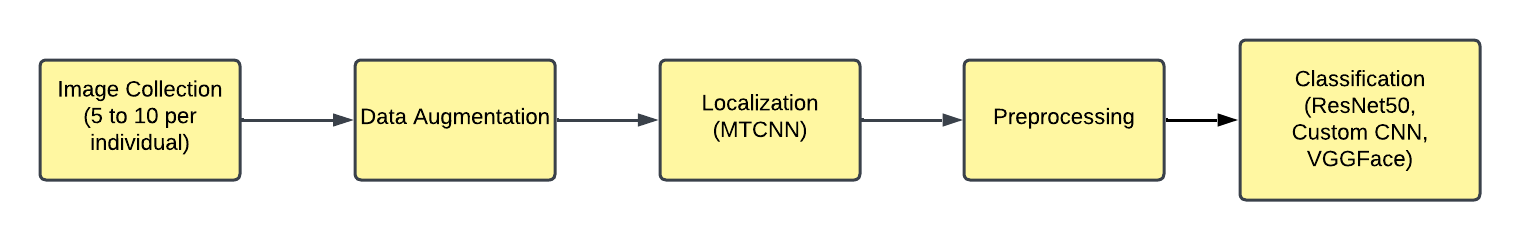

# **DEPENDENCIES**

In [ ]:
#import albumentations as A
#from facenet_pytorch import MTCNN
from PIL import Image
import os
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import shutil
import torch
from google.colab import drive
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.gridspec as gridspec
import json
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.optim import Adam, RMSprop, Adagrad
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from torchvision import models, transforms, datasets
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **DATASET AUGMENTATION (CUSTOM DATASET CREATION)**

In [ ]:
'''
This augmentation pipeline applies a series of random transformations, including
horizontal flips, rotations, brightness/contrast adjustments, shifts, scaling, and Gaussian blur,
to increase dataset diversity and improve model generalization.
'''

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.2),
])


In [ ]:
"""
This function performs image augmentation for each class in the input directory.
It applies the specified augmentation pipeline to every image, creating a given number
of augmented images per original image. The augmented images are then saved to the
output directory, preserving the class structure to ensure consistency for training.
"""

def augment_images(input_dir, output_dir, augment_count=10):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = np.array(Image.open(image_path))

            for i in range(augment_count):
                augmented = augmentation_pipeline(image=image)
                aug_image = Image.fromarray(augmented["image"])
                aug_image.save(os.path.join(output_class_path, f"{os.path.splitext(image_name)[0]}_aug{i}.jpg"))


In [ ]:
input_dir = "/content/input"
output_dir = "augmented_dataset"

augment_images(input_dir, output_dir)

# **LOCALIZATION - MTCNN**

MTCNN (Multi-Task Cascaded Convolutional Networks) is a deep learning-based framework designed for robust face detection and alignment. It performs three key tasks: detecting face bounding boxes, identifying facial landmarks (such as eyes, nose, and mouth corners), and refining face detection through multiple stages.

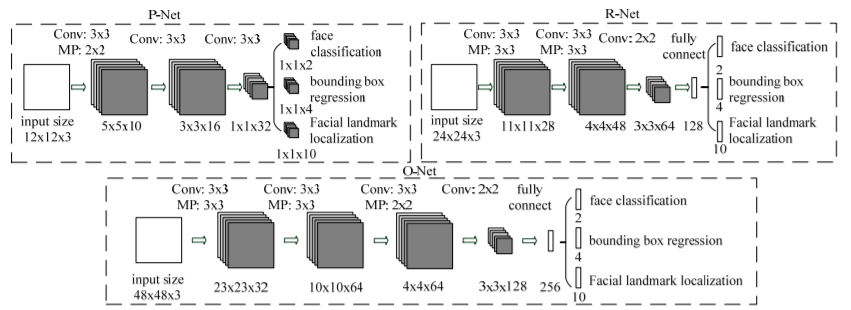

Since our dataset is not annotated, we are utilizing the ***Multi-task Cascaded Convolutional Network (MTCNN)*** to localize faces within the images. MTCNN is an effective deep learning-based face detection framework that accurately identifies and extracts facial regions. By leveraging this method, we can automatically detect and crop the faces, which prepares the dataset for further tasks such as training the facial recognition model. This approach ensures efficient preprocessing without the need for manual annotation.

In [ ]:
"""
Initializes the MTCNN (Multi-Task Cascaded Convolutional Networks) model for face detection
keep_all=True : Ensures that the model detects and processes multiple faces in a single image
device : Automatically selects 'cuda' for GPU acceleration if available, or defaults to 'cpu'
This configuration optimizes performance and enables efficient face detection on various hardware setups
"""
mtcnn = MTCNN(keep_all=True, device="cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
"""
This function performs face localization using the MTCNN model for all images in a given input directory
- The input directory should have subdirectories for each class containing images
- For each image, the function detects faces, crops the detected regions, and saves them into a corresponding
  subdirectory in the output directory
- Key Steps:
  1. Create the output directory structure to match the input directory
  2. Load each image, convert it to RGB format, and pass it to the MTCNN model for face detection
  3. If faces are detected, crop each face based on the bounding boxes provided by MTCNN
  4. Save the cropped faces as new image files with unique filenames in the corresponding output subdirectory
- If any error occurs during processing, it logs the error and moves to the next image
This ensures the creation of a well-organized dataset of cropped face images for further analysis or training
"""

def localize_faces_mtcnn(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Create output subdirectory for the class
        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                # Open the image
                image = Image.open(img_path).convert("RGB")

                # Detect faces
                boxes, _ = mtcnn.detect(image)

                if boxes is not None:
                    for i, box in enumerate(boxes):
                        # Crop face
                        cropped_face = image.crop(box)

                        # Save the cropped face
                        output_path = os.path.join(output_class_path, f"{os.path.splitext(img_name)[0]}_face{i}.jpg")
                        cropped_face.save(output_path)
                        print(f"Saved cropped face to: {output_path}")
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

In [ ]:
input_dir = "augmented_dataset"
output_dir = "localized_dataset_mtcnn"

In [ ]:
# Perform localization
localize_faces_mtcnn(input_dir, output_dir)

Saved cropped face to: localized_dataset_mtcnn/girish/photo_14_aug3_face0.jpg
Saved cropped face to: localized_dataset_mtcnn/girish/photo_10_aug6_face0.jpg
Saved cropped face to: localized_dataset_mtcnn/girish/photo_5_aug1_face0.jpg
Saved cropped face to: localized_dataset_mtcnn/girish/photo_11_aug8_face0.jpg
Saved cropped face to: localized_dataset_mtcnn/girish/photo_4_aug0_face0.jpg
Saved cropped face to: localized_dataset_mtcnn/girish/photo_14_aug9_face0.jpg
Saved cropped face to: localized_dataset_mtcnn/girish/photo_10_aug3_face0.jpg
Saved cropped face to: localized_dataset_mtcnn/girish/photo_7_aug1_face0.jpg
Saved cropped face to: localized_dataset_mtcnn/girish/photo_7_aug1_face1.jpg
Saved cropped face to: localized_dataset_mtcnn/girish/photo_4_aug2_face0.jpg
Saved cropped face to: localized_dataset_mtcnn/girish/photo_13_aug3_face0.jpg
Saved cropped face to: localized_dataset_mtcnn/girish/photo_7_aug9_face0.jpg
Saved cropped face to: localized_dataset_mtcnn/girish/photo_6_aug0_fac

# **SAVING THE LOCALIZED DATASET TO DRIVE**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths
output_dir = "localized_dataset_mtcnn"
drive_save_path = "/content/drive/My Drive/localized_dataset_mtcnn"

# Copy localized dataset to Google Drive
shutil.copytree(output_dir, drive_save_path)
print(f"Localized dataset saved to: {drive_save_path}")

Mounted at /content/drive
Localized dataset saved to: /content/drive/My Drive/localized_dataset_mtcnn


In [ ]:
dataset_path = "/content/drive/My Drive/localized_dataset_mtcnn"
output_dir = "/content/drive/My Drive/split_dataset"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
splits = ["train", "valid", "test"]
split_ratios = [0.7, 0.2, 0.1]

for split in splits:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

In [ ]:
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith((".jpg", ".png"))]

    # Skip if no images are found
    if len(images) == 0:
        print(f"Warning: No images found for class '{class_name}'. Skipping.")
        continue

    # Handle small datasets
    if len(images) < 10:  # Example threshold
        print(f"Warning: Too few images ({len(images)}) for class '{class_name}'. Assigning all to train.")
        train_imgs, valid_imgs, test_imgs = images, [], []
    else:
        # Split data
        train_imgs, temp_imgs = train_test_split(images, test_size=(1 - split_ratios[0]))
        valid_imgs, test_imgs = train_test_split(temp_imgs, test_size=(split_ratios[2] / (split_ratios[1] + split_ratios[2])))

    # Copy images to respective folders
    for img_list, split in zip([train_imgs, valid_imgs, test_imgs], splits):
        split_class_dir = os.path.join(output_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img in img_list:
            shutil.copy(img, os.path.join(split_class_dir, os.path.basename(img)))

print(f"Dataset split completed. Saved to: {output_dir}")

Dataset split completed. Saved to: /content/drive/My Drive/split_dataset


# **DATA PREPROCESSING**

In [ ]:
# Paths to the dataset
split_dataset_path = "/content/drive/My Drive/split_dataset"
train_dir = os.path.join(split_dataset_path, "train")
valid_dir = os.path.join(split_dataset_path, "valid")
test_dir = os.path.join(split_dataset_path, "test")



1.   **Resizing**: Ensures all images are resized to 224x224 pixels, which is the required input size for many models like ResNet.
2.   **Tensor Conversion**: Converts images into tensors, the format that models use for computations, and scales pixel values from [0, 255] to [0, 1].
3. **Normalization**: Standardizes the pixel values to have a mean of 0 and a standard deviation of 1, helping the model learn more efficiently and ensuring consistency with pre-trained models (like those trained on ImageNet).



In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #normalizing the pixel values
])

In [ ]:
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
valid_data = datasets.ImageFolder(root=valid_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

***PREPROCESSING RESULTS***

In [ ]:
# Check the first batch of the training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

print("Image shape:", images.shape)
print("Label shape:", labels.shape)
print("Number of unique labels:", len(set(labels.numpy())))

# Verify if the dataset has been split correctly
print(f"Train dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(valid_data)}")
print(f"Test dataset size: {len(test_data)}")

# Print the class-to-index mapping
print(f"Class to Index Mapping: {train_data.class_to_idx}")

Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])
Number of unique labels: 5
Train dataset size: 523
Validation dataset size: 149
Test dataset size: 79
Class to Index Mapping: {'anuvind': 0, 'ashwin': 1, 'girish': 2, 'hari': 3, 'harish': 4}


# **EXPLORATORY DATA ANALYSIS - CUSTOM DATASET**

The dataset used in this project is custom-designed, tailored specifically for the
development and evaluation of the attendance system. It was created by capturing
images of five individuals, namely Anuvind, Ashwin, Girish, Hari, and Harish. The
dataset is augmented using techniques such as rotation, scaling, flipping, and
brightness adjustment to increase its diversity and improve model generalization.



*   Source: Custom-collected dataset
*   Size: A total of 751 images, distributed across the training, validation, and testing stages






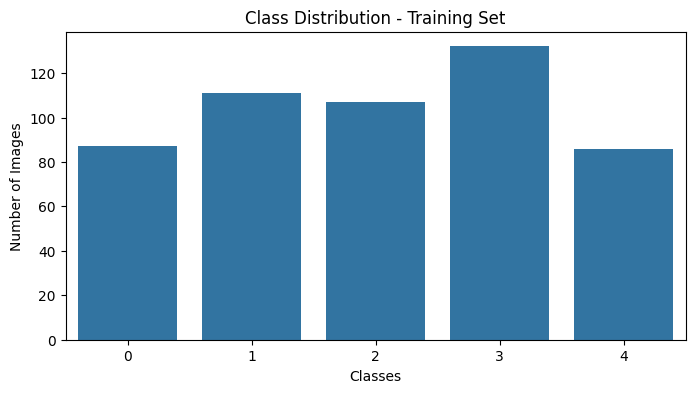

In [ ]:
def visualize_class_distribution(dataset, title):
    class_counts = Counter(dataset.targets)
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(8, 4))
    sns.barplot(x=classes, y=counts)
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()

visualize_class_distribution(train_data, "Class Distribution - Training Set")

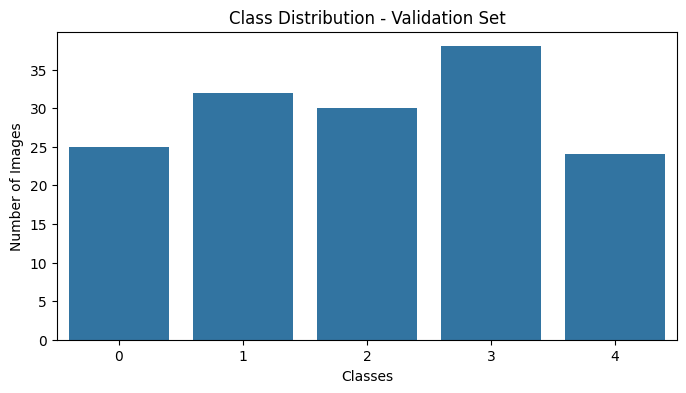

In [ ]:
# Visualize class distribution for the validation set
visualize_class_distribution(valid_data, "Class Distribution - Validation Set")


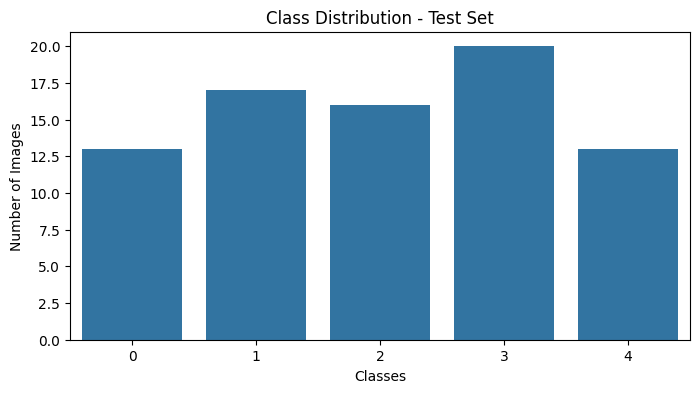

In [ ]:
# Visualize class distribution for the test set
visualize_class_distribution(test_data, "Class Distribution - Test Set")


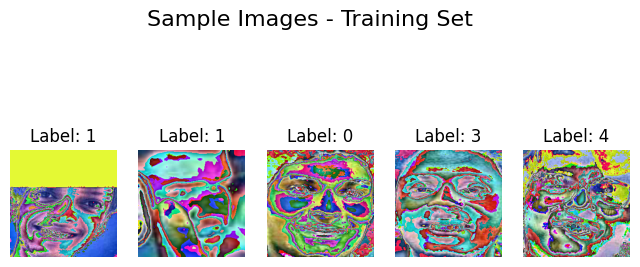

In [ ]:
# Function to display some sample images from the dataset
def display_sample_images(dataset, title, num_images=5):
    data_iter = iter(DataLoader(dataset, batch_size=num_images, shuffle=True))
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, num_images, figsize=(8, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(num_images):
        axes[i].imshow(transforms.ToPILImage()(images[i])) # Use ToPILImage() for correct display
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')

    plt.show()

# Display sample images for the training set
display_sample_images(train_data, "Sample Images - Training Set")


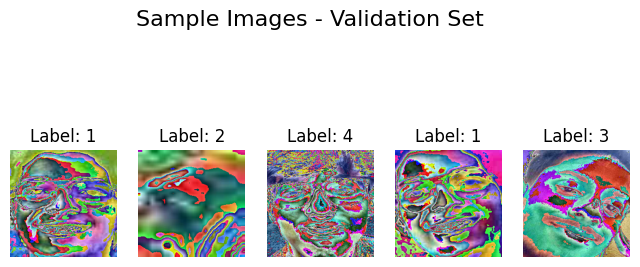

In [ ]:
display_sample_images(valid_data, "Sample Images - Validation Set")

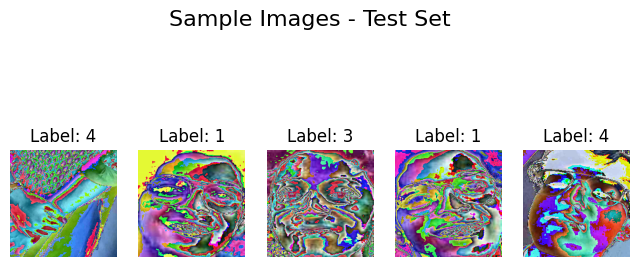

In [ ]:
# Display sample images for the test set
display_sample_images(test_data, "Sample Images - Test Set")


# **ResNet50**

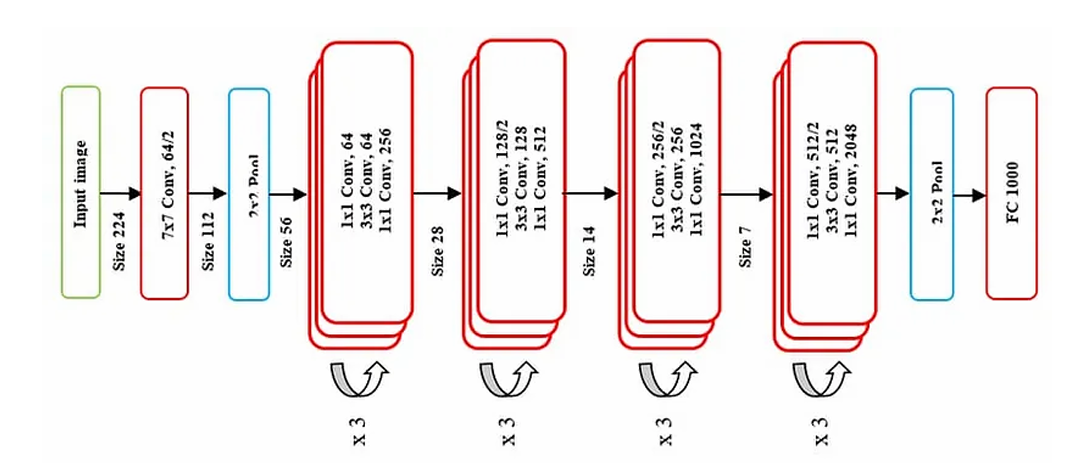

**<h2> Why ResNet50 ? </h2>**<br>
ResNet50 is chosen for its proven track record in achieving high accuracy
across various computer vision tasks. The residual learning mechanism
enables the network to maintain performance even at great depths, ensuring
precise feature extraction. Moreover, its widespread adoption and
availability of pre-trained weights on datasets such as ImageNet make it an
ideal starting point for fine-tuning on domain-specific tasks like facial
recognition.

In [ ]:
# Directories for saving checkpoints
drive_checkpoint_dir = '/content/drive/MyDrive/checkpoints/'
os.makedirs(drive_checkpoint_dir, exist_ok=True)

***Problem Faced: Runtime Disconnection*** <br>
One of the major challenges we encountered during the training process was frequent runtime disconnections. These interruptions occurred primarily due to resource limitations and extended training durations, leading to the loss of progress and incomplete execution of the model. This issue prevented us from directly plotting results and analyzing intermediate outcomes efficiently.

***Solution: Checkpointing with JSON*** <br>
To address the runtime disconnection problem, we implemented a solution using checkpoints stored in JSON files. During the training process, key parameters such as model weights, accuracy, and loss values were periodically saved in JSON format. This allowed us to resume training from the last saved state without starting over

In [ ]:
# Load completed configurations
completed_configs_path = os.path.join(drive_checkpoint_dir, 'completed_configs.json')
completed_configs = []
if os.path.exists(completed_configs_path):
    with open(completed_configs_path, 'r') as f:
        completed_configs = json.load(f)


 **<h1> TRAINING**

In [ ]:
# Hyperparameter grid
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32]
epochs = 10
optimizers = ["adam", "rmsprop", "adagrad"]

In [ ]:
# Initialize variables to track the best model
best_accuracy = 0
best_params = {}

In [ ]:
train_accuracies = {}
valid_accuracies = {}
hyperparam_results = {}

In [ ]:
"""
This code performs a grid search over different hyperparameters (learning rate, batch size, and optimizer) to train a ResNet50 model

- For each combination of hyperparameters, the model is reinitialized, and the data loaders are created with the specified batch size
- The optimizer is set based on the chosen optimizer type (Adam, RMSprop, or Adagrad) and learning rate
- The model is trained over multiple epochs, where after each epoch, training and validation accuracies are calculated and stored
- If a checkpoint exists for the current configuration, the training resumes from that checkpoint
- The best validation accuracy is tracked, and if the current model performs better than the previous one, it is saved as the best model
- A checkpoint is saved at the end of each epoch, containing the model and optimizer state, the current epoch, and the best accuracy so far
- After training is complete, the best validation accuracy for each hyperparameter combination is stored and marked as completed
- A configuration is considered completed if it has already been run, and such configurations are skipped to avoid redundant computations
"""


for lr in learning_rates:
    for batch_size in batch_sizes:
        for opt in optimizers:
            # Check if this configuration is already completed
            if {'lr': lr, 'batch_size': batch_size, 'optimizer': opt} in completed_configs:
                print(f"Skipping already completed configuration: lr={lr}, batch_size={batch_size}, optimizer={opt}")
                continue

            # Reinitialize the model, optimizer, and dataloaders for each combination
            resnet = models.resnet50(pretrained=True)
            num_features = resnet.fc.in_features
            num_classes = len(train_data.classes)  # Ensure train_data is defined elsewhere
            resnet.fc = nn.Linear(num_features, num_classes)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            resnet = resnet.to(device)

            # Define dataloaders with the current batch size
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

            # Set optimizer
            if opt == "adam":
                optimizer = optim.Adam(resnet.parameters(), lr=lr)
            elif opt == "rmsprop":
                optimizer = optim.RMSprop(resnet.parameters(), lr=lr)
            elif opt == "adagrad":
                optimizer = optim.Adagrad(resnet.parameters(), lr=lr)

            # Loss function
            criterion = nn.CrossEntropyLoss()

            # Store metrics for visualization
            key = f"lr={lr}_batch={batch_size}_opt={opt}"
            train_accuracies[key] = []
            valid_accuracies[key] = []

            # Check for an existing checkpoint
            checkpoint_path = os.path.join(drive_checkpoint_dir, f"checkpoint_resnet50_lr{lr}_batch{batch_size}_opt{opt}.pth")
            start_epoch = 0
            if os.path.exists(checkpoint_path):
                print(f"Resuming training from checkpoint: {checkpoint_path}")
                checkpoint = torch.load(checkpoint_path)
                resnet.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch'] + 1
                best_accuracy = checkpoint['best_accuracy']
                best_params = checkpoint['best_params']

            # Training Loop
            print(f"Training with learning rate: {lr}, batch size: {batch_size}, optimizer: {opt}")
            for epoch in range(start_epoch, epochs):
                print(f"Epoch {epoch + 1}/{epochs}")
                resnet.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = resnet(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                epoch_accuracy = 100 * correct / total
                train_accuracies[key].append(epoch_accuracy)

                # Validate after each epoch
                resnet.eval()
                valid_loss = 0.0
                correct = 0
                total = 0

                with torch.no_grad():
                    for images, labels in valid_loader:
                        images, labels = images.to(device), labels.to(device)
                        outputs = resnet(images)
                        loss = criterion(outputs, labels)
                        valid_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                valid_accuracy = 100 * correct / total
                valid_accuracies[key].append(valid_accuracy)

                # Keep track of the best performing hyperparameters
                if valid_accuracy > best_accuracy:
                    best_accuracy = valid_accuracy
                    best_params = {'learning_rate': lr, 'batch_size': batch_size, 'optimizer': opt}
                    # Save the best model checkpoint
                    torch.save(resnet.state_dict(), os.path.join(drive_checkpoint_dir, "best_resnet50.pth"))

                print(f"Train Accuracy: {epoch_accuracy:.2f}%, Validation Accuracy: {valid_accuracy:.2f}%")

                # Save a checkpoint after each epoch
                torch.save({
                    'model_state_dict': resnet.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch,
                    'best_accuracy': best_accuracy,
                    'best_params': best_params
                }, checkpoint_path)

            # Store the best validation accuracy for this hyperparameter set
            hyperparam_results[key] = max(valid_accuracies[key])

            # Mark this configuration as completed
            completed_configs.append({'lr': lr, 'batch_size': batch_size, 'optimizer': opt})
            with open(completed_configs_path, 'w') as f:
                json.dump(completed_configs, f)

Skipping already completed configuration: lr=0.01, batch_size=32, optimizer=adam
Skipping already completed configuration: lr=0.01, batch_size=32, optimizer=rmsprop


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 114MB/s]


Resuming training from checkpoint: /content/drive/MyDrive/checkpoints/checkpoint_resnet50_lr0.01_batch32_optadagrad.pth


<ipython-input-12-c593e7a11d43>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Training with learning rate: 0.01, batch size: 32, optimizer: adagrad
Epoch 10/10
Train Accuracy: 47.61%, Validation Accuracy: 38.26%
Training with learning rate: 0.001, batch size: 32, optimizer: adam
Epoch 1/10
Train Accuracy: 70.36%, Validation Accuracy: 47.65%
Epoch 2/10
Train Accuracy: 79.35%, Validation Accuracy: 70.47%
Epoch 3/10
Train Accuracy: 84.70%, Validation Accuracy: 73.15%
Epoch 4/10
Train Accuracy: 86.42%, Validation Accuracy: 89.93%
Epoch 5/10
Train Accuracy: 89.67%, Validation Accuracy: 89.93%
Epoch 6/10
Train Accuracy: 87.38%, Validation Accuracy: 73.15%
Epoch 7/10
Train Accuracy: 87.76%, Validation Accuracy: 78.52%
Epoch 8/10
Train Accuracy: 90.06%, Validation Accuracy: 85.23%
Epoch 9/10
Train Accuracy: 90.44%, Validation Accuracy: 91.28%
Epoch 10/10
Train Accuracy: 91.40%, Validation Accuracy: 90.60%
Training with learning rate: 0.001, batch size: 32, optimizer: rmsprop
Epoch 1/10
Train Accuracy: 21.03%, Validation Accuracy: 37.58%
Epoch 2/10
Train Accuracy: 25.05%

 **<h1> PLOTS**

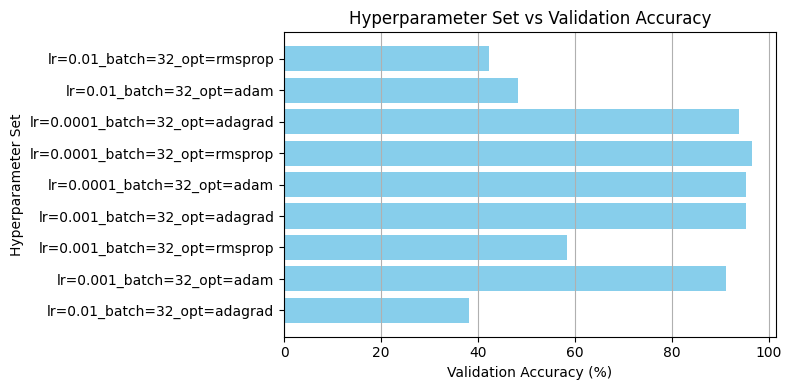

Hyperparameter Set vs Validation Accuracy:
lr=0.01_batch=32_opt=adagrad: 38.26%
lr=0.001_batch=32_opt=adam: 91.28%
lr=0.001_batch=32_opt=rmsprop: 58.39%
lr=0.001_batch=32_opt=adagrad: 95.30%
lr=0.0001_batch=32_opt=adam: 95.30%
lr=0.0001_batch=32_opt=rmsprop: 96.64%
lr=0.0001_batch=32_opt=adagrad: 93.96%
lr=0.01_batch=32_opt=adam: 48.32%
lr=0.01_batch=32_opt=rmsprop: 42.28%
Best Hyperparameters: {'learning_rate': 0.0001, 'batch_size': 32, 'optimizer': 'rmsprop'}
Best Validation Accuracy: 96.64%


In [ ]:
# Plot the hyperparameter set vs accuracy
plt.figure(figsize=(8, 4))
hyperparam_keys = list(hyperparam_results.keys())
hyperparam_accuracies = list(hyperparam_results.values())
plt.barh(hyperparam_keys, hyperparam_accuracies, color='skyblue')
plt.xlabel("Validation Accuracy (%)")
plt.ylabel("Hyperparameter Set")
plt.title("Hyperparameter Set vs Validation Accuracy")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Print the results
print("Hyperparameter Set vs Validation Accuracy:")
for key, accuracy in hyperparam_results.items():
    print(f"{key}: {accuracy:.2f}%")

print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")


<h4>Due to frequent runtime disconnections, we were unable to plot the graphs directly during the execution. As a solution, we manually stored the output values in a dictionary as in the code cell below, which were later used for plotting. This ensured that we could still analyze and visualize the results effectively despite the interruptions.

<ipython-input-22-a362b5a8dfe9>:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


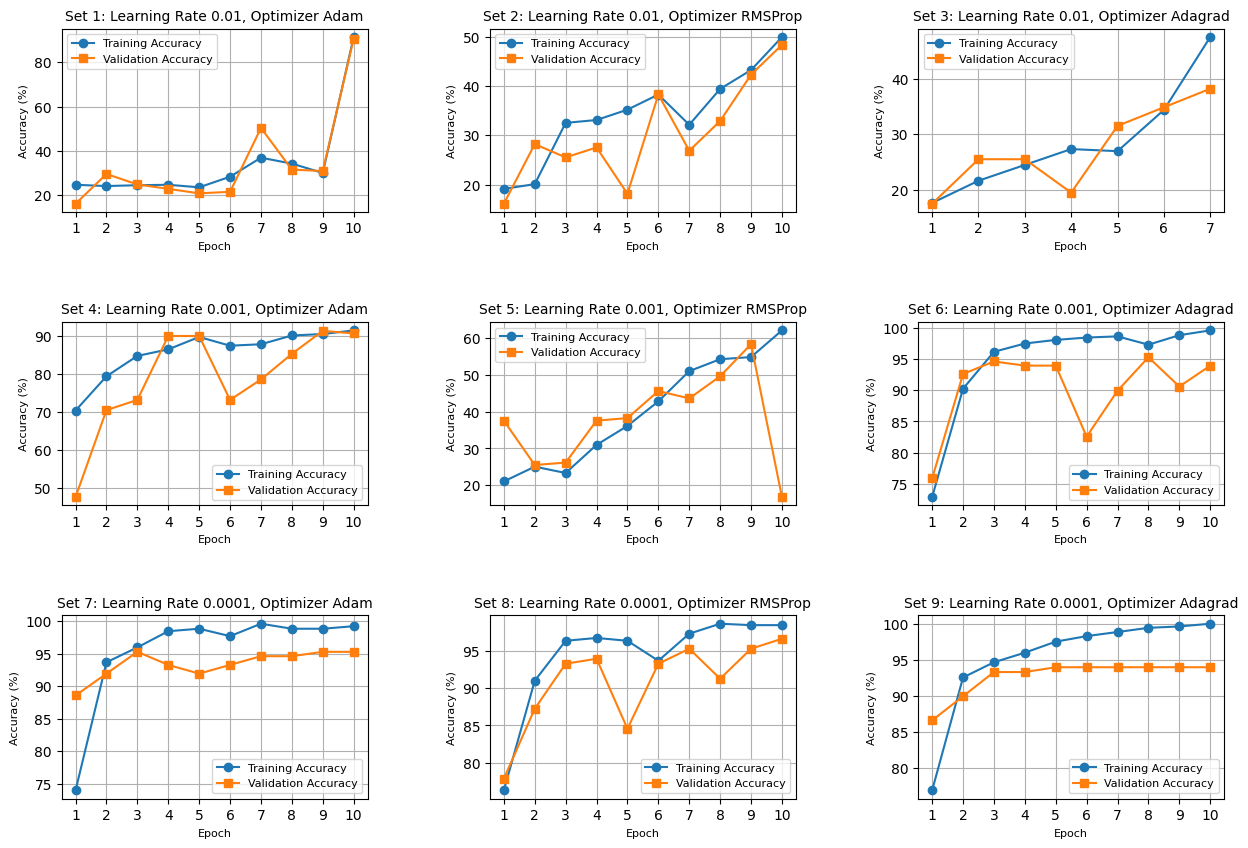

In [ ]:
def plot_epoch_vs_accuracy(train_accuracies, val_accuracies, epochs, title, ax):
    """
    Plots the epoch vs accuracy graph for training and validation datasets.

    Parameters:
        train_accuracies (list): List of training accuracies for each epoch.
        val_accuracies (list): List of validation accuracies for each epoch.
        epochs (int): Total number of epochs.
        title (str): Title for the plot.
        ax (matplotlib.axes.Axes): Axis object to plot on.
    """
    ax.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
    ax.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='s')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Epoch', fontsize=8)
    ax.set_ylabel('Accuracy (%)', fontsize=8)
    ax.set_xticks(range(1, epochs + 1))
    ax.legend(fontsize=8)
    ax.grid(True)

acc = [
    {
        'train_accuracies': [24.67, 24.09, 24.47, 24.67, 23.52, 28.30, 36.90, 34.23, 30.02, 91.40],
        'val_accuracies': [16.11, 29.53, 24.83, 22.82, 20.81, 21.48, 50.34, 31.54, 30.87, 90.60],
        'title': 'Set 1: Learning Rate 0.01, Optimizer Adam'
    },
    {
        'train_accuracies': [19.12, 20.08, 32.50, 33.08, 35.18, 38.24, 32.12, 39.39, 43.21, 49.90],
        'val_accuracies': [16.11, 28.19, 25.50, 27.52, 18.12, 38.26, 26.85, 32.89, 42.28, 48.32],
        'title': 'Set 2: Learning Rate 0.01, Optimizer RMSProp'
    },
    {
        'train_accuracies': [17.59, 21.61, 24.47, 27.34, 26.96, 34.42, 47.61],
        'val_accuracies': [17.45, 25.50, 25.50, 19.46, 31.54, 34.90, 38.26],
        'title': 'Set 3: Learning Rate 0.01, Optimizer Adagrad'
    },
    {
        'train_accuracies': [70.36, 79.35, 84.70, 86.42, 89.67, 87.38, 87.76, 90.06, 90.44, 91.40],
        'val_accuracies': [47.65, 70.47, 73.15, 89.93, 89.93, 73.15, 78.52, 85.23, 91.28, 90.60],
        'title': 'Set 4: Learning Rate 0.001, Optimizer Adam'
    },
    {
        'train_accuracies': [21.03, 25.05, 23.33, 30.98, 36.14, 42.83, 51.05, 54.30, 54.88, 62.14],
        'val_accuracies': [37.58, 25.50, 26.17, 37.58, 38.26, 45.64, 43.62, 49.66, 58.39, 16.78],
        'title': 'Set 5: Learning Rate 0.001, Optimizer RMSProp'
    },
    {
        'train_accuracies': [72.85, 90.25, 96.18, 97.51, 98.09, 98.47, 98.66, 97.32, 98.85, 99.62],
        'val_accuracies': [75.84, 92.62, 94.63, 93.96, 93.96, 82.55, 89.93, 95.30, 90.60, 93.96],
        'title': 'Set 6: Learning Rate 0.001, Optimizer Adagrad'
    },
    {
        'train_accuracies': [74.00, 93.69, 95.98, 98.47, 98.85, 97.71, 99.62, 98.85, 98.85, 99.24],
        'val_accuracies': [88.59, 91.95, 95.30, 93.29, 91.95, 93.29, 94.63, 94.63, 95.30, 95.30],
        'title': 'Set 7: Learning Rate 0.0001, Optimizer Adam'
    },
    {
        'train_accuracies': [76.29, 91.01, 96.37, 96.75, 96.37, 93.69, 97.32, 98.66, 98.47, 98.47],
        'val_accuracies': [77.85, 87.25, 93.29, 93.96, 84.56, 93.29, 95.30, 91.28, 95.30, 96.64],
        'title': 'Set 8: Learning Rate 0.0001, Optimizer RMSProp'
    },
    {
        'train_accuracies': [76.86, 92.54, 94.65, 95.98, 97.51, 98.28, 98.85, 99.43, 99.62, 100.00],
        'val_accuracies': [86.58, 89.93, 93.29, 93.29, 93.96, 93.96, 93.96, 93.96, 93.96, 93.96],
        'title': 'Set 9: Learning Rate 0.0001, Optimizer Adagrad'
    }
]

# Create a grid for the plots
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.4, hspace=0.6)

# Generate plots for each dataset
for idx, data in enumerate(acc):
    ax = fig.add_subplot(gs[idx // 3, idx % 3])
    plot_epoch_vs_accuracy(data['train_accuracies'], data['val_accuracies'], len(data['train_accuracies']), data['title'], ax)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_epoch_vs_accuracy(train_accuracies, val_accuracies, epochs, title):
    """
    Plots the epoch vs accuracy graph for training and validation datasets.

    Parameters:
        train_accuracies (list): List of training accuracies for each epoch.
        val_accuracies (list): List of validation accuracies for each epoch.
        epochs (int): Total number of epochs.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='s')

    plt.title(title, fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(range(1, epochs + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_final_accuracy_comparison(acc):
    """
    Plots a bar chart comparing final training and validation accuracies for all sets.

    Parameters:
        acc (list): List of dictionaries containing train_accuracies, val_accuracies, and titles for each set.
    """
    titles = [data['title'] for data in acc]
    final_train_accuracies = [data['train_accuracies'][-1] for data in acc]
    final_val_accuracies = [data['val_accuracies'][-1] for data in acc]

    x = np.arange(len(titles))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, final_train_accuracies, width, label='Training Accuracy')
    plt.bar(x + width/2, final_val_accuracies, width, label='Validation Accuracy')

    plt.title('Final Accuracy Comparison', fontsize=14)
    plt.xlabel('Sets', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(x, titles, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_optimizer_comparison(acc, learning_rate):
    """
    Plots a grouped bar chart comparing optimizers for a fixed learning rate.

    Parameters:
        acc (list): List of dictionaries containing train_accuracies, val_accuracies, and titles for each set.
        learning_rate (float): The learning rate to filter data sets.
    """
    filtered_data = [data for data in acc if f'Learning Rate {learning_rate}' in data['title']]
    optimizers = [data['title'].split('Optimizer ')[1] for data in filtered_data]
    avg_train_accuracies = [np.mean(data['train_accuracies']) for data in filtered_data]
    avg_val_accuracies = [np.mean(data['val_accuracies']) for data in filtered_data]

    x = np.arange(len(optimizers))
    width = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(x - width/2, avg_train_accuracies, width, label='Avg Training Accuracy')
    plt.bar(x + width/2, avg_val_accuracies, width, label='Avg Validation Accuracy')

    plt.title(f'Optimizer Comparison (Learning Rate {learning_rate})', fontsize=14)
    plt.xlabel('Optimizers', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(x, optimizers)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_learning_rate_impact(acc):
    """
    Plots a line graph showing the impact of learning rate on average accuracies.

    Parameters:
        acc (list): List of dictionaries containing train_accuracies, val_accuracies, and titles for each set.
    """
    learning_rates = sorted(set(float(data['title'].split('Learning Rate ')[1].split(',')[0]) for data in acc))
    avg_train_accuracies = []
    avg_val_accuracies = []

    for lr in learning_rates:
        filtered_data = [data for data in acc if f'Learning Rate {lr}' in data['title']]
        avg_train_accuracies.append(np.mean([np.mean(data['train_accuracies']) for data in filtered_data]))
        avg_val_accuracies.append(np.mean([np.mean(data['val_accuracies']) for data in filtered_data]))

    plt.figure(figsize=(8, 4))
    plt.plot(learning_rates, avg_train_accuracies, label='Avg Training Accuracy', marker='o')
    plt.plot(learning_rates, avg_val_accuracies, label='Avg Validation Accuracy', marker='s')

    plt.title('Impact of Learning Rate on Accuracy', fontsize=14)
    plt.xlabel('Learning Rate', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(learning_rates)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


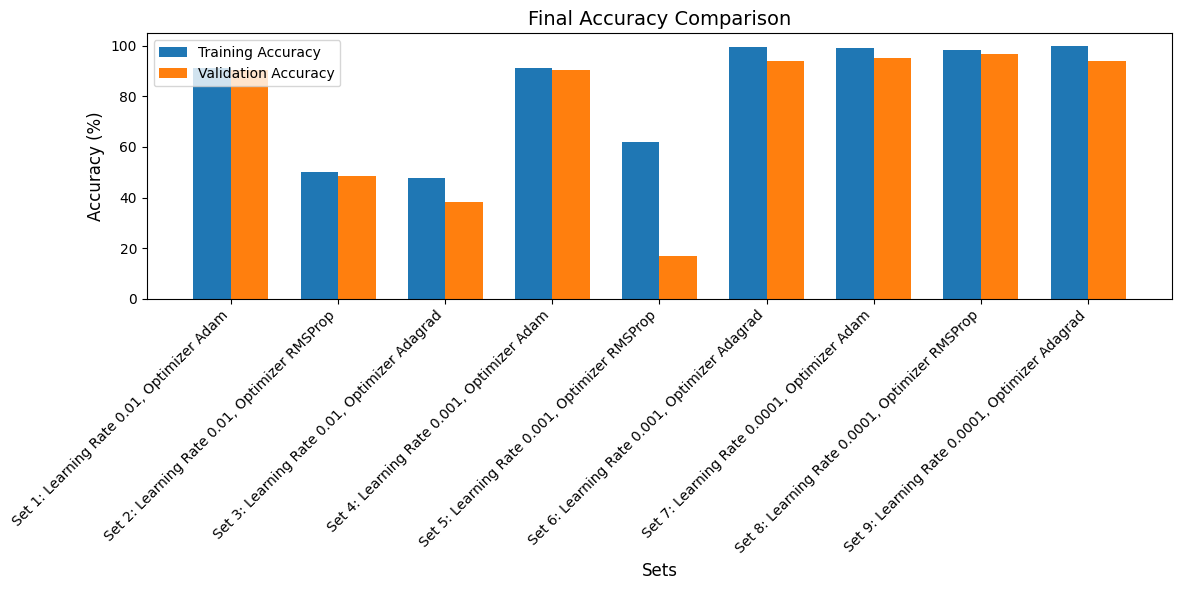

In [ ]:
# Generate additional plots
plot_final_accuracy_comparison(acc)

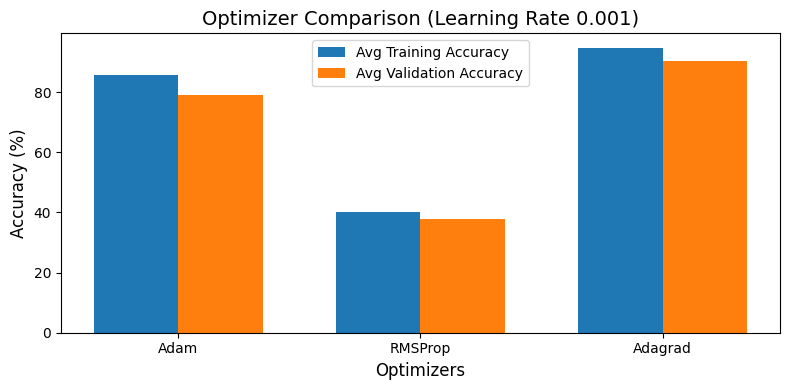

In [ ]:
plot_optimizer_comparison(acc, learning_rate=0.001)

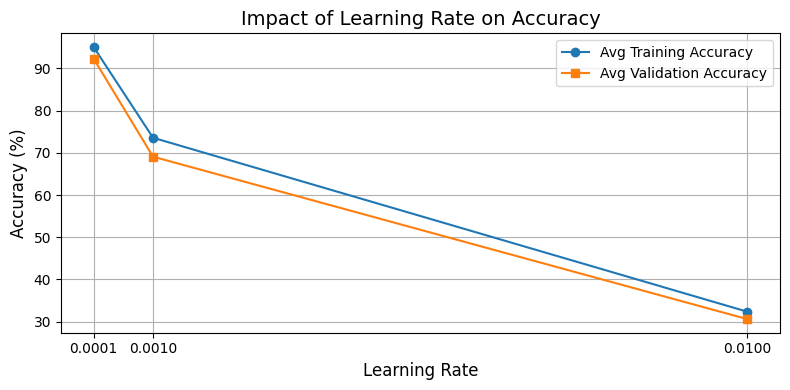

In [ ]:
plot_learning_rate_impact(acc)

# **Custom CNN**



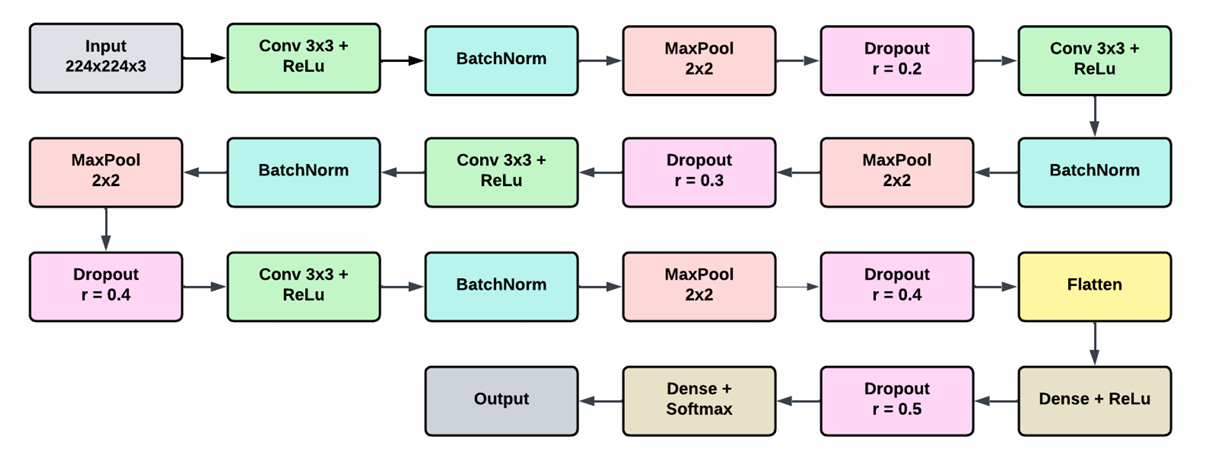

In [ ]:
"""
Converts batched image and label data from a PyTorch DataLoader into TensorFlow-compatible NumPy arrays.
The image format is changed from (batch, channels, height, width) to (batch, height, width, channels),
and all batches are concatenated into single arrays for both images and labels.
"""

def convert_to_tf(loader):
    images_list, labels_list = [], []
    for images, labels in loader:
        # Convert shape from (batch, channels, height, width) to (batch, height, width, channels)
        images = images.permute(0, 2, 3, 1).numpy()
        labels = labels.numpy()
        images_list.append(images)
        labels_list.append(labels)
    return np.concatenate(images_list, axis=0), np.concatenate(labels_list, axis=0)

# Convert train, validation loaders
train_images, train_labels = convert_to_tf(train_loader)
valid_images, valid_labels = convert_to_tf(valid_loader)

**<h2>TRAINING**

In [ ]:
"""
This code performs manual hyperparameter tuning for a Convolutional Neural Network (CNN) using TensorFlow/Keras.
The CNN processes input images of shape (224, 224, 3) with several convolutional, pooling, and dropout layers,
followed by fully connected layers and an output layer for 5-class classification.

Key Steps:
1. Parameter Tuning: Loops over different combinations of optimizers, learning rates, and batch sizes.
2. Model Creation: A function `create_model` defines and compiles the CNN model with specified hyperparameters.
3. Training and Validation: For each parameter set, the model is trained for up to 50 epochs,
   evaluating training and validation accuracy at each epoch.
4. Results Storage: Training and validation accuracies for each epoch and parameter set are stored.
5. Best Parameters: The model configuration with the highest validation accuracy is identified and displayed.

Hyperparameters tuned:
- Optimizers: 'adam', 'rmsprop', 'adagrad'
- Learning rates: [0.01, 0.001, 0.0001]
- Batch sizes: [32, 64]
"""

train_images = train_images
train_labels = train_labels
val_images = valid_images
val_labels = valid_labels

def create_model(optimizer='adam', learning_rate=0.001):
    model = Sequential()

    # Input Layer and First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))+--------------------------

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Fourth Convolutional Block
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(5, activation='softmax'))

    # Compile the model
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        opt = Adagrad(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Parameter ranges
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64]
optimizers = ['adam', 'rmsprop', 'adagrad']

# Manual parameter tuning loop
results = []
best_val_accuracy = 0
best_params = {}

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for optimizer in optimizers:
            print(f"\nTesting parameters: optimizer={optimizer}, learning_rate={learning_rate}, batch_size={batch_size}")

            # Create the model
            model = create_model(optimizer=optimizer, learning_rate=learning_rate)
            epoch_train_accuracies = []
            epoch_val_accuracies = []

            for epoch in range(1, 51):
                history = model.fit(
                    train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=1,  # Train for 1 epoch at a time
                    batch_size=batch_size,
                    verbose=0
                )

                # Evaluate on training and validation data
                train_accuracy = model.evaluate(train_images, train_labels, verbose=0)[1]
                val_accuracy = model.evaluate(val_images, val_labels, verbose=0)[1]
                epoch_train_accuracies.append(train_accuracy)
                epoch_val_accuracies.append(val_accuracy)

                print(f"Epoch {epoch}: Training accuracy = {train_accuracy:.4f}, Validation accuracy = {val_accuracy:.4f}")

                # Update best parameters if validation accuracy improves
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_params = {
                        'optimizer': optimizer,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size,
                        'epochs': epoch
                    }

            # Store results for parameter set
            results.append({
                'parameters': f"opt={optimizer}, lr={learning_rate}, batch={batch_size}",
                'train_accuracies': epoch_train_accuracies,
                'val_accuracies': epoch_val_accuracies
            })

print("\nBest Parameters:")
print(best_params)
print(f"Best Validation Accuracy: {best_val_accuracy}")


Testing parameters: optimizer=adam, learning_rate=0.01, batch_size=32
Epoch 1: Training accuracy = 0.1587, Validation accuracy = 0.1208
Epoch 2: Training accuracy = 0.2428, Validation accuracy = 0.2886
Epoch 3: Training accuracy = 0.2906, Validation accuracy = 0.2953
Epoch 4: Training accuracy = 0.2237, Validation accuracy = 0.2013
Epoch 5: Training accuracy = 0.2065, Validation accuracy = 0.2013
Epoch 6: Training accuracy = 0.2562, Validation accuracy = 0.2550
Epoch 7: Training accuracy = 0.2696, Validation accuracy = 0.2953
Epoch 8: Training accuracy = 0.2868, Validation accuracy = 0.3087
Epoch 9: Training accuracy = 0.2830, Validation accuracy = 0.3087
Epoch 10: Training accuracy = 0.2868, Validation accuracy = 0.3020
Epoch 11: Training accuracy = 0.3518, Validation accuracy = 0.3289
Epoch 12: Training accuracy = 0.3824, Validation accuracy = 0.3557
Epoch 13: Training accuracy = 0.4034, Validation accuracy = 0.3691
Epoch 14: Training accuracy = 0.3748, Validation accuracy = 0.3758


 **<h1> PLOTS**

***Batch Size 32 results***

<ipython-input-20-7b987664d932>:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


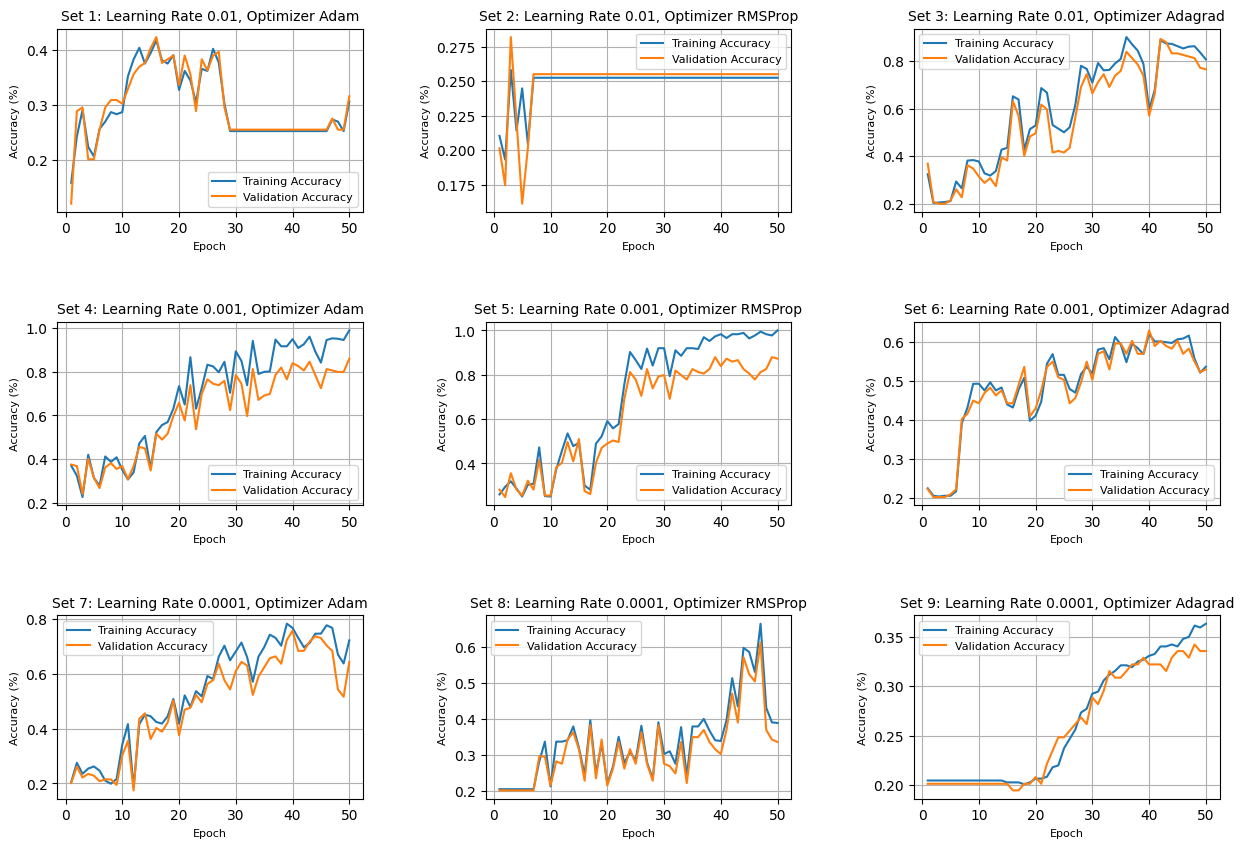

In [ ]:
def plot_epoch_vs_accuracy(train_accuracies, val_accuracies, epochs, title, ax):
    """
    Plots the epoch vs accuracy graph for training and validation datasets.

    Parameters:
        train_accuracies (list): List of training accuracies for each epoch.
        val_accuracies (list): List of validation accuracies for each epoch.
        epochs (int): Total number of epochs.
        title (str): Title for the plot.
        ax (matplotlib.axes.Axes): Axis object to plot on.
    """
    ax.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    ax.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Epoch', fontsize=8)
    ax.set_ylabel('Accuracy (%)', fontsize=8)
    ax.legend(fontsize=8)
    ax.grid(True)

acc32 = [
    {
        'train_accuracies':[0.1587, 0.2428, 0.2906, 0.2237, 0.2065, 0.2562, 0.2696, 0.2868, 0.283, 0.2868, 0.3518, 0.3824, 0.4034, 0.3748, 0.3939, 0.4168, 0.3805, 0.3748, 0.3901, 0.327, 0.3614, 0.3442, 0.304, 0.3652, 0.3614, 0.4015, 0.3767, 0.3021, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2734, 0.2696, 0.2524, 0.3059],
        'val_accuracies': [0.1208, 0.2886, 0.2953, 0.2013, 0.2013, 0.255, 0.2953, 0.3087, 0.3087, 0.302, 0.3289, 0.3557, 0.3691, 0.3758, 0.4027, 0.4228, 0.3758, 0.3826, 0.3893, 0.3356, 0.3893, 0.3557, 0.2886, 0.3826, 0.3624, 0.3893, 0.396, 0.2953, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.2752, 0.255, 0.255, 0.3154],
        'title': 'Set 1: Learning Rate 0.01, Optimizer Adam'
    },
    {
        'train_accuracies': [0.2103, 0.1931, 0.2581, 0.2141, 0.2447, 0.2046, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524],
        'val_accuracies': [0.2013, 0.1745, 0.2819, 0.2215, 0.1611, 0.2013, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255],
        'title': 'Set 2: Learning Rate 0.01, Optimizer RMSProp'
    },
    {
        'train_accuracies': [0.325, 0.2046, 0.2065, 0.2084, 0.2122, 0.2945, 0.2658, 0.3824, 0.3843, 0.3786, 0.3289, 0.3193, 0.3384, 0.4283, 0.4359, 0.652, 0.6386, 0.4264, 0.5143, 0.5296, 0.6864, 0.6673, 0.5315, 0.5163, 0.501, 0.522, 0.6157, 0.7801, 0.7667, 0.7094, 0.7916, 0.761, 0.7629, 0.7897, 0.8088, 0.9006, 0.87, 0.8432, 0.7878, 0.5966, 0.6788, 0.8872, 0.8738, 0.8719, 0.8623, 0.8528, 0.8604, 0.8623, 0.8356, 0.8069],
        'val_accuracies': [0.3691, 0.2081, 0.2013, 0.2013, 0.2148, 0.2617, 0.2282, 0.3624, 0.349, 0.3154, 0.2886, 0.3087, 0.2752, 0.396, 0.3826, 0.6309, 0.5705, 0.4027, 0.4832, 0.4966, 0.6174, 0.5973, 0.4161, 0.4228, 0.4161, 0.4362, 0.5638, 0.6913, 0.745, 0.6644, 0.7114, 0.745, 0.6913, 0.7383, 0.7584, 0.8389, 0.8121, 0.7852, 0.7383, 0.5705, 0.6644, 0.8926, 0.8792, 0.8322, 0.8322, 0.8255, 0.8188, 0.8121, 0.7718, 0.7651],
        'title': 'Set 3: Learning Rate 0.01, Optimizer Adagrad'
    },
    {
        'train_accuracies': [0.3709, 0.325, 0.2275, 0.4207, 0.3155, 0.2792, 0.413, 0.3881, 0.4092, 0.3518, 0.3078, 0.3403, 0.4723, 0.5067, 0.3576, 0.5239, 0.5564, 0.5698, 0.631, 0.7342, 0.6501, 0.8662, 0.631, 0.7247, 0.8317, 0.8241, 0.7973, 0.8451, 0.7036, 0.8929, 0.8489, 0.738, 0.9407, 0.7897, 0.7992, 0.8011, 0.9465, 0.9159, 0.9159, 0.9484, 0.9082, 0.9254, 0.9598, 0.8929, 0.8413, 0.9446, 0.9522, 0.9503, 0.9446, 0.9885],
        'val_accuracies': [0.3758, 0.3691, 0.2416, 0.4027, 0.3154, 0.2685, 0.3624, 0.3826, 0.3557, 0.3691, 0.3087, 0.3691, 0.4564, 0.4497, 0.349, 0.5168, 0.4899, 0.5168, 0.5973, 0.6577, 0.5772, 0.7383, 0.5369, 0.698, 0.7651, 0.745, 0.7383, 0.7584, 0.6242, 0.7852, 0.745, 0.5973, 0.8121, 0.6711, 0.6913, 0.698, 0.7852, 0.8188, 0.7651, 0.8389, 0.8255, 0.8054, 0.8456, 0.7852, 0.7248, 0.8121, 0.8054, 0.7987, 0.7987, 0.8591],
        'title': 'Set 4: Learning Rate 0.001, Optimizer Adam'
    },
    {
        'train_accuracies': [0.26, 0.2945, 0.3193, 0.2868, 0.2505, 0.304, 0.3078, 0.4723, 0.2524, 0.2505, 0.3728, 0.457, 0.5354, 0.478, 0.4933, 0.3002, 0.2811, 0.4895, 0.522, 0.5908, 0.5583, 0.5774, 0.7572, 0.9025, 0.8662, 0.826, 0.9178, 0.8413, 0.9197, 0.9197, 0.7935, 0.9101, 0.8853, 0.9197, 0.9197, 0.9159, 0.9694, 0.9522, 0.9732, 0.9828, 0.9656, 0.9828, 0.9828, 0.9885, 0.9637, 0.9771, 0.9943, 0.9828, 0.9771, 1.0],
        'val_accuracies': [0.2819, 0.2483, 0.3557, 0.2819, 0.255, 0.3221, 0.2819, 0.4161, 0.255, 0.255, 0.3826, 0.4027, 0.4966, 0.4094, 0.5101, 0.2752, 0.2617, 0.4027, 0.4698, 0.4899, 0.5034, 0.4966, 0.6913, 0.8121, 0.7785, 0.7047, 0.8255, 0.7383, 0.7919, 0.7987, 0.6913, 0.8188, 0.7987, 0.7785, 0.8255, 0.8121, 0.8054, 0.8255, 0.8792, 0.8389, 0.8725, 0.8591, 0.8658, 0.8255, 0.8054, 0.7785, 0.8121, 0.8255, 0.8792, 0.8725],
        'title': 'Set 5: Learning Rate 0.001, Optimizer RMSProp'
    },
    {
        'train_accuracies': [0.2237, 0.2046, 0.2027, 0.2046, 0.2046, 0.2161, 0.392, 0.4321, 0.4933, 0.4933, 0.4761, 0.4971, 0.4761, 0.4837, 0.4398, 0.4321, 0.478, 0.5086, 0.3977, 0.4111, 0.4474, 0.5449, 0.5698, 0.5163, 0.5163, 0.4799, 0.4704, 0.5182, 0.5373, 0.5201, 0.5813, 0.5851, 0.5564, 0.6138, 0.5946, 0.5488, 0.5966, 0.5851, 0.5698, 0.6214, 0.6023, 0.6023, 0.6004, 0.5985, 0.608, 0.6099, 0.6176, 0.5583, 0.522, 0.5373],
        'val_accuracies': [0.2215, 0.2013, 0.2013, 0.2013, 0.2081, 0.2215, 0.4027, 0.4161, 0.4497, 0.443, 0.4698, 0.4832, 0.4631, 0.4765, 0.443, 0.443, 0.4899, 0.5369, 0.4094, 0.4295, 0.4765, 0.5369, 0.5503, 0.5101, 0.5034, 0.443, 0.4564, 0.4966, 0.5503, 0.5034, 0.5705, 0.5772, 0.5302, 0.5973, 0.5973, 0.5705, 0.604, 0.5705, 0.5705, 0.6309, 0.5906, 0.604, 0.5906, 0.5839, 0.604, 0.5705, 0.5839, 0.5503, 0.5235, 0.5302],
        'title': 'Set 6: Learning Rate 0.001, Optimizer Adagrad'
    },
    {
        'train_accuracies': [0.2046, 0.2753, 0.2352, 0.2543, 0.262, 0.2467, 0.2103, 0.1989, 0.2161, 0.3423, 0.4168, 0.1855, 0.4168, 0.4512, 0.4455, 0.4245, 0.4187, 0.4455, 0.5086, 0.4187, 0.522, 0.4799, 0.5373, 0.5182, 0.5927, 0.5813, 0.6635, 0.7036, 0.6501, 0.6826, 0.7151, 0.6616, 0.5717, 0.6635, 0.6979, 0.7438, 0.7323, 0.7036, 0.7839, 0.7686, 0.7323, 0.6979, 0.7132, 0.7476, 0.7476, 0.7782, 0.7686, 0.6711, 0.6386, 0.7228],
        'val_accuracies': [0.2013, 0.2617, 0.2215, 0.2349, 0.2282, 0.2081, 0.2148, 0.2148, 0.1946, 0.302, 0.3557, 0.1745, 0.4362, 0.4564, 0.3624, 0.4027, 0.3893, 0.4228, 0.5034, 0.3758, 0.4698, 0.4765, 0.5235, 0.4966, 0.5638, 0.5772, 0.6376, 0.5772, 0.5436, 0.6107, 0.6443, 0.6309, 0.5235, 0.5906, 0.6242, 0.6577, 0.6644, 0.6376, 0.7248, 0.7584, 0.6846, 0.6846, 0.7181, 0.7383, 0.7315, 0.7047, 0.6846, 0.5436, 0.5168, 0.6443],
        'title': 'Set 7: Learning Rate 0.0001, Optimizer Adam'
    },
    {
        'train_accuracies': [0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2811, 0.3365, 0.2122, 0.3365, 0.3365, 0.3403, 0.3786, 0.3193, 0.2447, 0.3958, 0.2486, 0.3308, 0.2199, 0.2677, 0.3499, 0.2772, 0.3078, 0.2849, 0.3805, 0.2792, 0.2333, 0.3901, 0.3021, 0.3098, 0.2753, 0.3767, 0.2409, 0.3786, 0.3786, 0.3996, 0.3671, 0.3403, 0.3384, 0.3958, 0.5124, 0.434, 0.5966, 0.5851, 0.5296, 0.6635, 0.4302, 0.3901, 0.3881],
        'val_accuracies': [0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2953, 0.2953, 0.2148, 0.2819, 0.2752, 0.3423, 0.3624, 0.3154, 0.2282, 0.3826, 0.2349, 0.3423, 0.2148, 0.2617, 0.3356, 0.2617, 0.3154, 0.2752, 0.3624, 0.2752, 0.2282, 0.3826, 0.2752, 0.2685, 0.2483, 0.3356, 0.2215, 0.349, 0.349, 0.3691, 0.3356, 0.3154, 0.302, 0.3691, 0.4698, 0.3893, 0.5705, 0.5235, 0.5034, 0.6107, 0.3691, 0.3423, 0.3356],
        'title': 'Set 8: Learning Rate 0.0001, Optimizer RMSProp'
    },
    {
        'train_accuracies': [0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2027, 0.2027, 0.2027, 0.2008, 0.2027, 0.2065, 0.2065, 0.2084, 0.218, 0.2199, 0.2371, 0.2467, 0.2562, 0.2734, 0.2772, 0.2925, 0.2945, 0.3059, 0.3117, 0.3155, 0.3212, 0.3212, 0.3193, 0.325, 0.327, 0.3308, 0.3327, 0.3403, 0.3403, 0.3423, 0.3403, 0.348, 0.3499, 0.3614, 0.3595, 0.3633],
        'val_accuracies': [0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.1946, 0.1946, 0.2013, 0.2013, 0.2081, 0.2013, 0.2215, 0.2349, 0.2483, 0.2483, 0.255, 0.2617, 0.2685, 0.2617, 0.2886, 0.2819, 0.2953, 0.3154, 0.3087, 0.3087, 0.3154, 0.3221, 0.3221, 0.3289, 0.3221, 0.3221, 0.3221, 0.3154, 0.3289, 0.3356, 0.3356, 0.3289, 0.3423, 0.3356, 0.3356],
        'title': 'Set 9: Learning Rate 0.0001, Optimizer Adagrad'
    }
]

# Create a grid for the plots
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.4, hspace=0.6)

# Generate plots for each dataset
for idx, data in enumerate(acc32):
    ax = fig.add_subplot(gs[idx // 3, idx % 3])
    plot_epoch_vs_accuracy(data['train_accuracies'], data['val_accuracies'], len(data['train_accuracies']), data['title'], ax)

plt.tight_layout()
plt.show()


In [ ]:
max_acc=[]
for i in range(9):
  max_acc.append(max(acc32[i]['val_accuracies']))

In [ ]:
titles=[]
for i in range(9):
  titles.append(acc32[i]['title'])

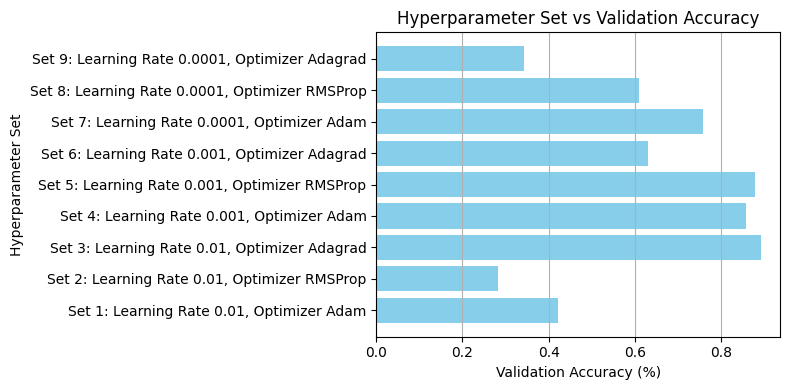

In [ ]:
# Plot the hyperparameter set vs accuracy
plt.figure(figsize=(8, 4))
hyperparam_keys = titles
hyperparam_accuracies = max_acc
plt.barh(hyperparam_keys, hyperparam_accuracies, color='skyblue')
plt.xlabel("Validation Accuracy (%)")
plt.ylabel("Hyperparameter Set")
plt.title("Hyperparameter Set vs Validation Accuracy")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

***Batch size 64 results***

<ipython-input-39-e6e88aa0eb37>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


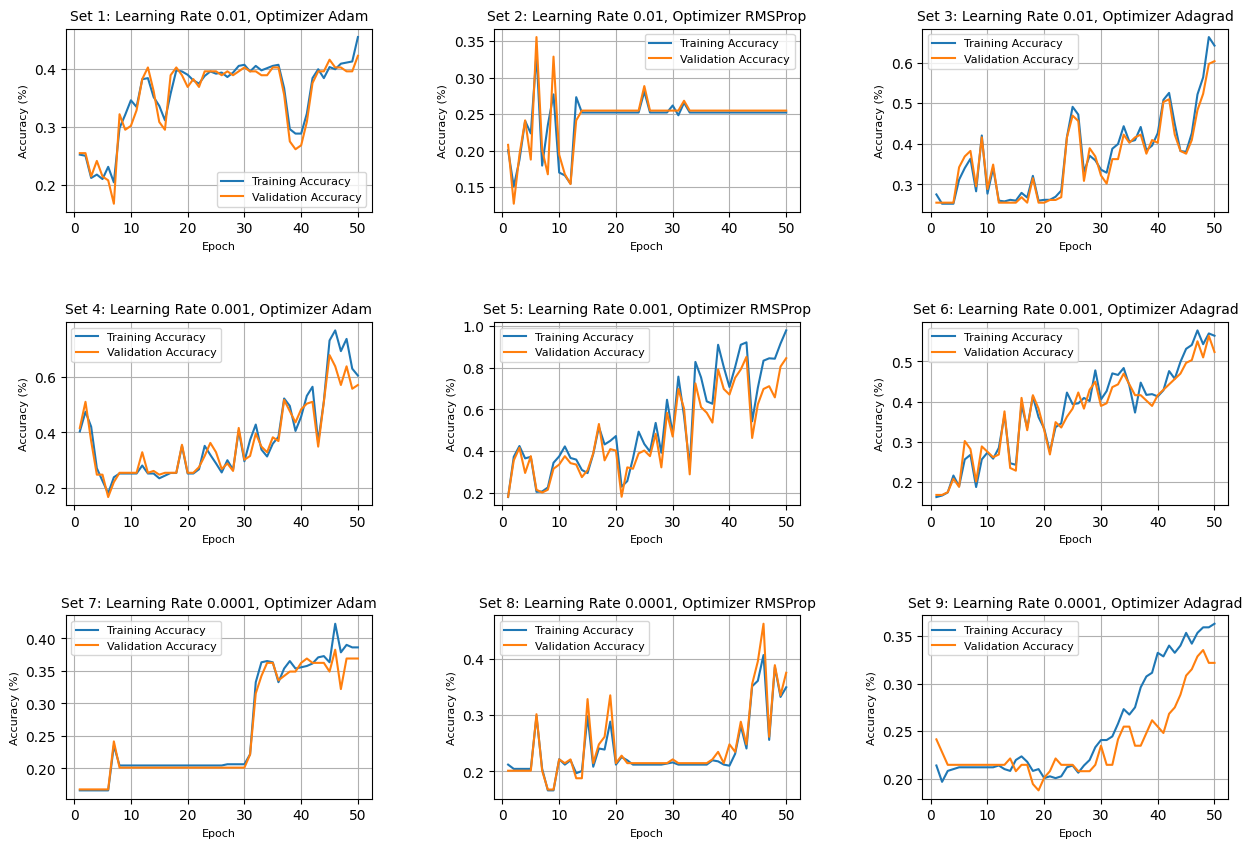

In [ ]:
acc64 = [
    {
        'train_accuracies':[0.2524, 0.2505, 0.2122, 0.218, 0.2103, 0.2314, 0.2046, 0.2983, 0.3212, 0.3461, 0.3346, 0.3824, 0.3843, 0.3518, 0.3365, 0.3117, 0.3576, 0.3977, 0.3958, 0.3901, 0.3805, 0.3748, 0.3881, 0.3958, 0.392, 0.3939, 0.3862, 0.3939, 0.4054, 0.4073, 0.3958, 0.4054, 0.3977, 0.4015, 0.4054, 0.4073, 0.3671, 0.2964, 0.2887, 0.2887, 0.3231, 0.3843, 0.3996, 0.3843, 0.4034, 0.3996, 0.4092, 0.4111, 0.413, 0.4551],
        'val_accuracies': [0.255, 0.255, 0.2148, 0.2416, 0.2148, 0.2081, 0.1678, 0.3221, 0.2953, 0.302, 0.3289, 0.3826, 0.4027, 0.3624, 0.3087, 0.2953, 0.3893, 0.4027, 0.3893, 0.3691, 0.3826, 0.3691, 0.396, 0.396, 0.396, 0.3893, 0.396, 0.3893, 0.396, 0.4027, 0.396, 0.396, 0.3893, 0.3893, 0.4027, 0.4027, 0.3557, 0.2752, 0.2617, 0.2685, 0.3087, 0.3758, 0.396, 0.396, 0.4161, 0.4027, 0.4027, 0.396, 0.396, 0.4228],
        'title': 'Set 1: Learning Rate 0.01, Optimizer Adam'
    },
    {
        'train_accuracies': [0.2008, 0.1511, 0.1874, 0.2409, 0.2237, 0.3327, 0.1797, 0.2352, 0.2772, 0.1702, 0.1663, 0.1549, 0.2734, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2811, 0.2524, 0.2524, 0.2524, 0.2524, 0.262, 0.2486, 0.2658, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524, 0.2524],
        'val_accuracies': [0.2081, 0.1275, 0.1946, 0.2416, 0.1879, 0.3557, 0.2013, 0.1678, 0.3289, 0.1946, 0.1678, 0.1544, 0.2416, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.2886, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.2685, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255, 0.255],
        'title': 'Set 2: Learning Rate 0.01, Optimizer RMSProp'
    },
    {
        'train_accuracies': [0.2753, 0.2524, 0.2524, 0.2524, 0.3117, 0.3403, 0.3633, 0.283, 0.4207, 0.2772, 0.3403, 0.26, 0.2581, 0.262, 0.26, 0.2792, 0.2677, 0.3212, 0.26, 0.262, 0.262, 0.2696, 0.2849, 0.4168, 0.4914, 0.4723, 0.3308, 0.3709, 0.3595, 0.3365, 0.3289, 0.3881, 0.3996, 0.4436, 0.4054, 0.4092, 0.4417, 0.3843, 0.3958, 0.4264, 0.5086, 0.5258, 0.4493, 0.3824, 0.3805, 0.4264, 0.522, 0.5641, 0.6635, 0.6424],
        'val_accuracies': [0.255, 0.255, 0.255, 0.255, 0.3423, 0.3691, 0.3826, 0.2953, 0.4161, 0.2886, 0.349, 0.255, 0.255, 0.255, 0.255, 0.2685, 0.255, 0.3154, 0.255, 0.255, 0.2617, 0.2617, 0.2685, 0.4161, 0.4698, 0.4564, 0.3087, 0.3893, 0.3691, 0.3221, 0.302, 0.3624, 0.3624, 0.4228, 0.4027, 0.4161, 0.4228, 0.3758, 0.4094, 0.4027, 0.5034, 0.5101, 0.4228, 0.3826, 0.3758, 0.4094, 0.4832, 0.5235, 0.5973, 0.604],
        'title': 'Set 3: Learning Rate 0.01, Optimizer Adagrad'
    },
    {
        'train_accuracies': [0.4034, 0.4742, 0.4207, 0.2715, 0.2256, 0.1816, 0.239, 0.2524, 0.2524, 0.2524, 0.2524, 0.2811, 0.2524, 0.2524, 0.2352, 0.2447, 0.2543, 0.2543, 0.3518, 0.2524, 0.2524, 0.2677, 0.3518, 0.3193, 0.2887, 0.2562, 0.3002, 0.2658, 0.4073, 0.2964, 0.3728, 0.4283, 0.3384, 0.3136, 0.3595, 0.3843, 0.522, 0.4952, 0.4054, 0.457, 0.5315, 0.5641, 0.3652, 0.5124, 0.7304, 0.7667, 0.6922, 0.7361, 0.6291, 0.6042],
        'val_accuracies': [0.4161, 0.5101, 0.3691, 0.2483, 0.2483, 0.1678, 0.2215, 0.255, 0.255, 0.255, 0.255, 0.3289, 0.255, 0.2617, 0.2483, 0.255, 0.255, 0.255, 0.3557, 0.255, 0.255, 0.2752, 0.3154, 0.3624, 0.3289, 0.2685, 0.2886, 0.2617, 0.4161, 0.302, 0.3154, 0.396, 0.349, 0.3289, 0.3826, 0.3691, 0.5168, 0.4765, 0.4362, 0.4832, 0.5034, 0.5101, 0.349, 0.5101, 0.6779, 0.6376, 0.5705, 0.6376, 0.557, 0.5705],
        'title': 'Set 4: Learning Rate 0.001, Optimizer Adam'
    },
    {
        'train_accuracies': [0.1797, 0.3728, 0.4245, 0.3652, 0.3728, 0.2046, 0.2065, 0.2256, 0.3442, 0.3748, 0.4226, 0.3671, 0.3595, 0.3098, 0.2945, 0.3862, 0.5163, 0.4321, 0.4493, 0.4723, 0.2294, 0.2562, 0.3652, 0.4933, 0.434, 0.3977, 0.5354, 0.392, 0.6463, 0.4818, 0.7572, 0.5679, 0.3231, 0.8279, 0.7533, 0.6386, 0.6272, 0.9101, 0.8031, 0.7075, 0.8031, 0.9101, 0.9216, 0.543, 0.7036, 0.8337, 0.8451, 0.8432, 0.9159, 0.979],
        'val_accuracies': [0.1812, 0.3557, 0.4161, 0.2953, 0.3758, 0.2148, 0.2013, 0.2148, 0.3154, 0.3356, 0.3758, 0.3423, 0.3356, 0.2752, 0.3087, 0.3893, 0.5302, 0.3557, 0.4094, 0.4027, 0.1812, 0.3221, 0.3154, 0.3893, 0.4027, 0.3758, 0.4832, 0.3221, 0.5839, 0.4698, 0.698, 0.604, 0.2886, 0.7248, 0.6107, 0.5839, 0.5369, 0.7919, 0.698, 0.6711, 0.7517, 0.7919, 0.8523, 0.4631, 0.6242, 0.698, 0.7114, 0.6577, 0.8054, 0.8456],
        'title': 'Set 5: Learning Rate 0.001, Optimizer RMSProp'
    },
    {
        'train_accuracies': [0.1625, 0.1663, 0.174, 0.2161, 0.1893, 0.2562, 0.2677, 0.1874, 0.2562, 0.2734, 0.2581, 0.2849, 0.3671, 0.2467, 0.2428, 0.392, 0.3346, 0.413, 0.3614, 0.3327, 0.2753, 0.3365, 0.3461, 0.4226, 0.3939, 0.3958, 0.4092, 0.4015, 0.478, 0.4054, 0.4264, 0.4704, 0.4665, 0.4837, 0.4398, 0.3728, 0.4474, 0.4168, 0.4187, 0.413, 0.4283, 0.4761, 0.457, 0.499, 0.5315, 0.5411, 0.5774, 0.543, 0.5698, 0.5641],
        'val_accuracies': [0.1678, 0.1678, 0.1745, 0.2081, 0.1879, 0.302, 0.2819, 0.2013, 0.2886, 0.2752, 0.2617, 0.2685, 0.3758, 0.2349, 0.2282, 0.4094, 0.3289, 0.4161, 0.3826, 0.3289, 0.2685, 0.349, 0.3356, 0.3624, 0.3826, 0.4228, 0.3826, 0.4295, 0.4497, 0.3893, 0.396, 0.4362, 0.443, 0.4698, 0.443, 0.4161, 0.4161, 0.4027, 0.3893, 0.4161, 0.4295, 0.443, 0.4564, 0.4698, 0.4966, 0.5034, 0.5503, 0.5101, 0.5638, 0.5235],
        'title': 'Set 6: Learning Rate 0.001, Optimizer Adagrad'
    },
    {
        'train_accuracies': [0.1663, 0.1663, 0.1663, 0.1663, 0.1663, 0.1663, 0.2352, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2046, 0.2065, 0.2065, 0.2065, 0.2065, 0.2218, 0.3327, 0.3633, 0.3652, 0.3633, 0.3327, 0.3537, 0.3652, 0.3537, 0.3556, 0.3576, 0.3614, 0.3709, 0.3728, 0.3633, 0.4226, 0.3786, 0.3901, 0.3862, 0.3862],
        'val_accuracies': [0.1678, 0.1678, 0.1678, 0.1678, 0.1678, 0.1678, 0.2416, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.2215, 0.3154, 0.3423, 0.3624, 0.3624, 0.3356, 0.3423, 0.349, 0.349, 0.3624, 0.3691, 0.3624, 0.3624, 0.3624, 0.349, 0.3826, 0.3221, 0.3691, 0.3691, 0.3691],
        'title': 'Set 7: Learning Rate 0.0001, Optimizer Adam'
    },
    {
        'train_accuracies': [0.2122, 0.2046, 0.2046, 0.2046, 0.2046, 0.2983, 0.2046, 0.1663, 0.1663, 0.2218, 0.2122, 0.2199, 0.1969, 0.2008, 0.2983, 0.2084, 0.2409, 0.239, 0.2887, 0.2122, 0.2256, 0.2199, 0.2122, 0.2122, 0.2122, 0.2122, 0.2122, 0.2122, 0.2141, 0.2161, 0.2122, 0.2122, 0.2122, 0.2122, 0.2122, 0.2122, 0.2199, 0.218, 0.2122, 0.2103, 0.2314, 0.2811, 0.2409, 0.3518, 0.3614, 0.4073, 0.2562, 0.3862, 0.3327, 0.3499],
        'val_accuracies': [0.2013, 0.2013, 0.2013, 0.2013, 0.2013, 0.302, 0.2013, 0.1678, 0.1678, 0.2215, 0.2148, 0.2215, 0.1879, 0.1879, 0.3289, 0.2148, 0.2483, 0.2617, 0.3356, 0.2148, 0.2282, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2215, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2215, 0.2349, 0.2148, 0.2483, 0.2349, 0.2886, 0.2483, 0.3557, 0.396, 0.4631, 0.2617, 0.3893, 0.3356, 0.3758],
        'title': 'Set 8: Learning Rate 0.0001, Optimizer RMSProp'
    },
    {
        'train_accuracies': [0.2141, 0.1969, 0.2084, 0.2103, 0.2122, 0.2122, 0.2122, 0.2122, 0.2122, 0.2122, 0.2122, 0.2141, 0.2103, 0.2084, 0.2199, 0.2237, 0.218, 0.2084, 0.2103, 0.2008, 0.2027, 0.2008, 0.2027, 0.2122, 0.2141, 0.2065, 0.2141, 0.2199, 0.2333, 0.2409, 0.2409, 0.2447, 0.2581, 0.2734, 0.2677, 0.2753, 0.2964, 0.3078, 0.3117, 0.3327, 0.3289, 0.3403, 0.3327, 0.3403, 0.3537, 0.3423, 0.3537, 0.3595, 0.3595, 0.3633],
        'val_accuracies': [0.2416, 0.2282, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2215, 0.2081, 0.2148, 0.2148, 0.1946, 0.1879, 0.2013, 0.2081, 0.2215, 0.2148, 0.2148, 0.2148, 0.2081, 0.2081, 0.2081, 0.2148, 0.2349, 0.2148, 0.2148, 0.2416, 0.255, 0.255, 0.2349, 0.2349, 0.2483, 0.2617, 0.255, 0.2483, 0.2685, 0.2752, 0.2886, 0.3087, 0.3154, 0.3289, 0.3356, 0.3221, 0.3221],
        'title': 'Set 9: Learning Rate 0.0001, Optimizer Adagrad'
    }
]

# Create a grid for the plots
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.4, hspace=0.6)

# Generate plots for each dataset
for idx, data in enumerate(acc64):
    ax = fig.add_subplot(gs[idx // 3, idx % 3])
    plot_epoch_vs_accuracy(data['train_accuracies'], data['val_accuracies'], len(data['train_accuracies']), data['title'], ax)

plt.tight_layout()
plt.show()


In [ ]:
max_acc64=[]
for i in range(9):
  max_acc64.append(max(acc64[i]['val_accuracies']))

In [ ]:
titles64=[]
for i in range(9):
  titles64.append(acc64[i]['title'])

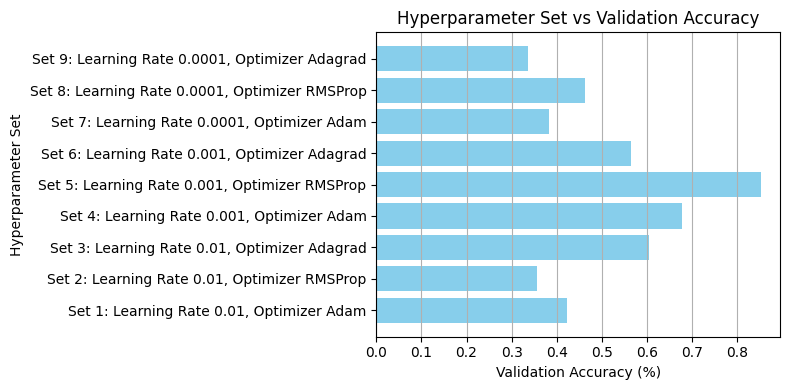

In [ ]:
# Plot the hyperparameter set vs accuracy
plt.figure(figsize=(8, 4))
hyperparam_keys = titles64
hyperparam_accuracies = max_acc64
plt.barh(hyperparam_keys, hyperparam_accuracies, color='skyblue')
plt.xlabel("Validation Accuracy (%)")
plt.ylabel("Hyperparameter Set")
plt.title("Hyperparameter Set vs Validation Accuracy")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


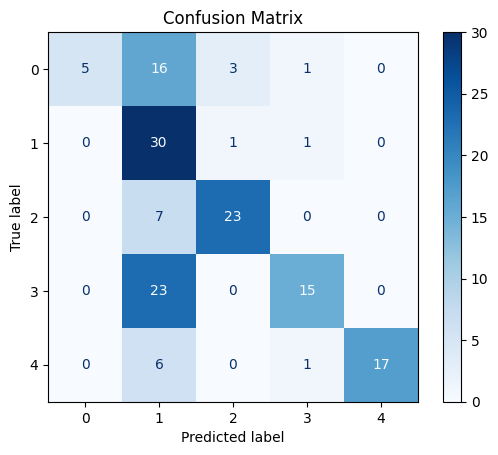

In [ ]:
# Generate confusion matrix for the best model
best_model = create_model(optimizer=best_params['optimizer'], learning_rate=best_params['learning_rate'])
best_model.fit(train_images, train_labels, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
predictions = np.argmax(best_model.predict(val_images), axis=1)
cm = confusion_matrix(val_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# **VGGFace**

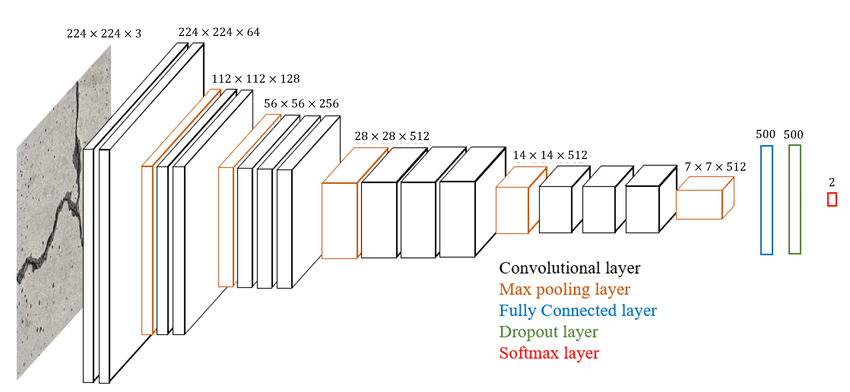

We used VGG16 because of its proven performance and simplicity for image recognition tasks. Its deep yet straightforward architecture enables it to extract hierarchical features effectively, making it ideal for facial recognition tasks where fine details are crucial. Additionally, VGG16's pre-trained weights on large-scale datasets like ImageNet provide a solid starting point, reducing training time and improving accuracy, especially when dealing with small or limited datasets. This transfer learning approach allows the model to generalize well to our specific problem while leveraging the knowledge learned from vast image data.

In [ ]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

***PREPROCESSING FOR VGG***

In [ ]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGGFace expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard VGG normalization
])

In [ ]:
# Load datasets
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
valid_data = datasets.ImageFolder(root=valid_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

**<h2> TRAINING </h2>**

In [ ]:
# Hyperparameter grid
learning_rates = [0.01, 0.001, 0.0001]
optimizers = ["adam", "rmsprop", "adagrad"]

In [ ]:
# Initialize variables for tracking the best model
best_accuracy = 0
best_params = {}
history = {}

In [ ]:
# Loop over hyperparameter combinations
for lr, opt in product(learning_rates, optimizers):
    print(f"\nTraining with learning rate {lr} and optimizer {opt}")

    # Load pretrained VGG16 model
    vggface = models.vgg16(pretrained=True)
    vggface.classifier[6] = nn.Linear(in_features=4096, out_features=len(train_data.classes))
    vggface = vggface.to(device)

    # Define optimizer
    if opt == "adam":
        optimizer = Adam(vggface.parameters(), lr=lr)
    elif opt == "rmsprop":
        optimizer = RMSprop(vggface.parameters(), lr=lr)
    elif opt == "adagrad":
        optimizer = Adagrad(vggface.parameters(), lr=lr)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Training loop
    num_epochs = 25
    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        vggface.train()
        train_correct, train_total, train_loss = 0, 0, 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = vggface(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        train_accuracy = train_correct / train_total
        train_acc.append(train_accuracy)

        # Validation loop
        vggface.eval()
        val_correct, val_total, val_loss = 0, 0, 0.0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = vggface(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        val_acc.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'learning_rate': lr, 'optimizer': opt}
            torch.save(vggface.state_dict(), "/content/drive/My Drive/best_vggface_model.pth")

    # Store history for this hyperparameter set
    history[f"lr_{lr}_opt_{opt}"] = {'train_acc': train_acc, 'val_acc': val_acc}


Training with learning rate 0.01 and optimizer adam
Epoch 1/25, Train Acc: 0.1989, Val Acc: 0.2013
Epoch 2/25, Train Acc: 0.2008, Val Acc: 0.1678
Epoch 3/25, Train Acc: 0.2103, Val Acc: 0.1611
Epoch 4/25, Train Acc: 0.2027, Val Acc: 0.2013
Epoch 5/25, Train Acc: 0.2141, Val Acc: 0.2550
Epoch 6/25, Train Acc: 0.2008, Val Acc: 0.2550
Epoch 7/25, Train Acc: 0.2103, Val Acc: 0.1678
Epoch 8/25, Train Acc: 0.1969, Val Acc: 0.1678
Epoch 9/25, Train Acc: 0.2103, Val Acc: 0.1678
Epoch 10/25, Train Acc: 0.2428, Val Acc: 0.1611
Epoch 11/25, Train Acc: 0.1797, Val Acc: 0.2148
Epoch 12/25, Train Acc: 0.1969, Val Acc: 0.2148
Epoch 13/25, Train Acc: 0.2065, Val Acc: 0.2148
Epoch 14/25, Train Acc: 0.2161, Val Acc: 0.2148
Epoch 15/25, Train Acc: 0.2275, Val Acc: 0.2148
Epoch 16/25, Train Acc: 0.2371, Val Acc: 0.2550
Epoch 17/25, Train Acc: 0.2486, Val Acc: 0.2550
Epoch 18/25, Train Acc: 0.2505, Val Acc: 0.2550
Epoch 19/25, Train Acc: 0.2352, Val Acc: 0.2550
Epoch 20/25, Train Acc: 0.2467, Val Acc: 0.2

In [ ]:
print(f"\nBest hyperparameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")


Best hyperparameters: {'learning_rate': 0.0001, 'optimizer': 'adam'}
Best validation accuracy: 0.9664


In [ ]:
# Load the best model
vggface.load_state_dict(torch.load("/content/drive/My Drive/best_vggface_model.pth"))
vggface = vggface.to(device)

In [ ]:
# Evaluate on test set
vggface.eval()
y_true, y_pred = [], []

In [ ]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vggface(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=train_data.classes))


Classification Report:
               precision    recall  f1-score   support

     anuvind       1.00      0.92      0.96        13
      ashwin       0.84      0.94      0.89        17
      girish       0.93      0.88      0.90        16
        hari       0.95      1.00      0.98        20
      harish       0.92      0.85      0.88        13

    accuracy                           0.92        79
   macro avg       0.93      0.92      0.92        79
weighted avg       0.93      0.92      0.92        79



 **<h1> PLOTS**

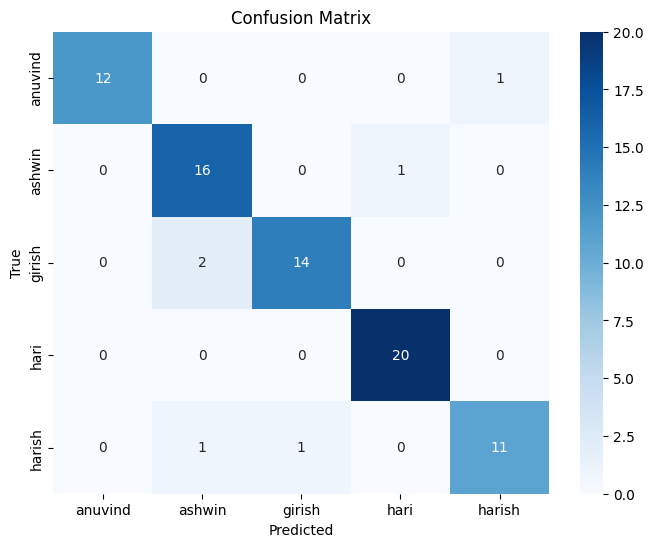

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
acc = [
    {
        'train_accuracies':  [0.1989, 0.2008, 0.2103, 0.2027, 0.2141, 0.2008, 0.2103, 0.1969, 0.2103, 0.2428, 0.1797, 0.1969, 0.2065, 0.2161, 0.2275, 0.2371, 0.2486, 0.2505, 0.2352, 0.2467, 0.2428, 0.2447, 0.2581, 0.2620, 0.2620],
        'val_accuracies': [0.2013, 0.1678, 0.1611, 0.2013, 0.2550, 0.2550, 0.1678, 0.1678, 0.1678, 0.1611, 0.2148, 0.2148, 0.2148, 0.2148, 0.2148, 0.2550, 0.2550, 0.2550, 0.2550, 0.2550, 0.2550, 0.2550, 0.2550, 0.2550, 0.2550],
        'title': 'Set 1: Learning Rate 0.01, Optimizer Adam'
    },
    {
        'train_accuracies': [0.2027, 0.2008, 0.2046, 0.2065, 0.1969, 0.2390, 0.1778, 0.1989, 0.2084, 0.1816, 0.2065, 0.1874, 0.2065, 0.2333, 0.2103, 0.2161, 0.1969, 0.2199, 0.2218, 0.1836, 0.1969, 0.2084, 0.2141, 0.2046, 0.2352],
        'val_accuracies':  [0.2081, 0.2081, 0.1611, 0.2215, 0.2215, 0.2215, 0.2215, 0.2215, 0.2215, 0.2215, 0.2349, 0.2349, 0.2349, 0.2550, 0.2483, 0.2483, 0.2081, 0.2013, 0.1678, 0.1745, 0.1812, 0.1745, 0.1745, 0.1678, 0.1678],
        'title': 'Set 2: Learning Rate 0.01, Optimizer RMSProp'
    },
    {
        'train_accuracies': [0.2218, 0.2218, 0.2084, 0.2084, 0.2180, 0.2447, 0.2715, 0.2524, 0.2620, 0.2753, 0.3423, 0.2199, 0.2218, 0.2371, 0.3098, 0.2792, 0.2524, 0.3250, 0.3250, 0.3786, 0.3939, 0.5277, 0.5602, 0.4990, 0.5034],
        'val_accuracies': [0.1611, 0.1611, 0.2416, 0.2013, 0.2819, 0.2953, 0.2953, 0.2215, 0.2550, 0.3087, 0.2013, 0.2483, 0.2215, 0.2550, 0.2148, 0.2617, 0.2416, 0.3691, 0.3087, 0.3557, 0.3423, 0.6711, 0.6040, 0.5034, 0.5034],
        'title': 'Set 3: Learning Rate 0.01, Optimizer Adagrad'
    },
    {
        'train_accuracies': [0.2917, 0.3118, 0.3306, 0.3550, 0.3541, 0.3651, 0.3697, 0.3841, 0.3995, 0.4120, 0.4236, 0.4411, 0.4515, 0.4575, 0.4630, 0.4714, 0.4771, 0.4849, 0.4910, 0.4960, 0.5027, 0.5083, 0.5144, 0.5202, 0.5256],
        'val_accuracies': [0.3474, 0.3509, 0.3586, 0.3655, 0.3734, 0.3802, 0.3872, 0.3939, 0.4007, 0.4076, 0.4143, 0.4211, 0.4278, 0.4346, 0.4414, 0.4481, 0.4548, 0.4615, 0.4682, 0.4748, 0.4815, 0.4882, 0.4949, 0.5015, 0.5082],
        'title': 'Set 4: Learning Rate 0.001, Optimizer Adam'
    },
    {
        'train_accuracies': [0.2549, 0.2803, 0.3036, 0.3221, 0.3352, 0.3481, 0.3592, 0.3711, 0.3816, 0.3940, 0.4064, 0.4172, 0.4277, 0.4382, 0.4485, 0.4595, 0.4702, 0.4807, 0.4910, 0.5013, 0.5113, 0.5212, 0.5310, 0.5407, 0.5502],
        'val_accuracies': [0.3456, 0.3489, 0.3559, 0.3619, 0.3680, 0.3742, 0.3804, 0.3866, 0.3927, 0.3988, 0.4048, 0.4109, 0.4169, 0.4230, 0.4289, 0.4350, 0.4411, 0.4471, 0.4532, 0.4593, 0.4654, 0.4714, 0.4775, 0.4835, 0.4895],
        'title': 'Set 5: Learning Rate 0.001, Optimizer RMSProp'
    },
    {
        'train_accuracies': [0.2135, 0.2340, 0.2564, 0.2774, 0.2961, 0.3165, 0.3365, 0.3555, 0.3741, 0.3919, 0.4095, 0.4264, 0.4432, 0.4599, 0.4766, 0.4934, 0.5101, 0.5267, 0.5433, 0.5600, 0.5767, 0.5934, 0.6101, 0.6268, 0.6435],
        'val_accuracies': [0.3001, 0.3143, 0.3277, 0.3411, 0.3544, 0.3676, 0.3808, 0.3938, 0.4068, 0.4197, 0.4326, 0.4455, 0.4583, 0.4710, 0.4837, 0.4963, 0.5088, 0.5212, 0.5336, 0.5459, 0.5581, 0.5702, 0.5823, 0.5943, 0.6063],
        'title': 'Set 6: Learning Rate 0.001, Optimizer Adagrad'
    },
    {
        'train_accuracies': [0.2544, 0.2690, 0.2859, 0.3008, 0.3155, 0.3303, 0.3447, 0.3589, 0.3731, 0.3868, 0.4005, 0.4137, 0.4263, 0.4387, 0.4512, 0.4630, 0.4748, 0.4862, 0.4973, 0.5083, 0.5190, 0.5294, 0.5396, 0.5496, 0.5594],
        'val_accuracies':  [0.3539, 0.3602, 0.3667, 0.3730, 0.3793, 0.3856, 0.3918, 0.3979, 0.4039, 0.4098, 0.4157, 0.4216, 0.4275, 0.4333, 0.4391, 0.4448, 0.4505, 0.4562, 0.4619, 0.4675, 0.4731, 0.4786, 0.4841, 0.4895, 0.4950],
        'title': 'Set 7: Learning Rate 0.0001, Optimizer Adam'
    },
    {
        'train_accuracies': [0.2321, 0.2525, 0.2743, 0.2948, 0.3152, 0.3355, 0.3552, 0.3746, 0.3938, 0.4126, 0.4312, 0.4495, 0.4677, 0.4856, 0.5034, 0.5210, 0.5384, 0.5556, 0.5727, 0.5897, 0.6065, 0.6232, 0.6397, 0.6560, 0.6722],
        'val_accuracies': [0.3418, 0.3482, 0.3543, 0.3604, 0.3665, 0.3726, 0.3786, 0.3846, 0.3905, 0.3964, 0.4022, 0.4079, 0.4136, 0.4193, 0.4250, 0.4306, 0.4362, 0.4417, 0.4472, 0.4527, 0.4581, 0.4635, 0.4689, 0.4742, 0.4795],
        'title': 'Set 8: Learning Rate 0.0001, Optimizer RMSProp'
    },
    {
        'train_accuracies':[0.2114, 0.2287, 0.2458, 0.2617, 0.2775, 0.2932, 0.3088, 0.3242, 0.3395, 0.3546, 0.3697, 0.3845, 0.3992, 0.4137, 0.4280, 0.4422, 0.4561, 0.4699, 0.4835, 0.4969, 0.5101, 0.5231, 0.5359, 0.5485, 0.5610],
        'val_accuracies': [0.3524, 0.3572, 0.3620, 0.3667, 0.3714, 0.3760, 0.3805, 0.3849, 0.3893, 0.3936, 0.3978, 0.4020, 0.4062, 0.4103, 0.4143, 0.4183, 0.4223, 0.4262, 0.4301, 0.4339, 0.4376, 0.4413, 0.4449, 0.4485, 0.4520],
        'title': 'Set 9: Learning Rate 0.0001, Optimizer Adagrad'
    }
]


<ipython-input-54-3006b845683e>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


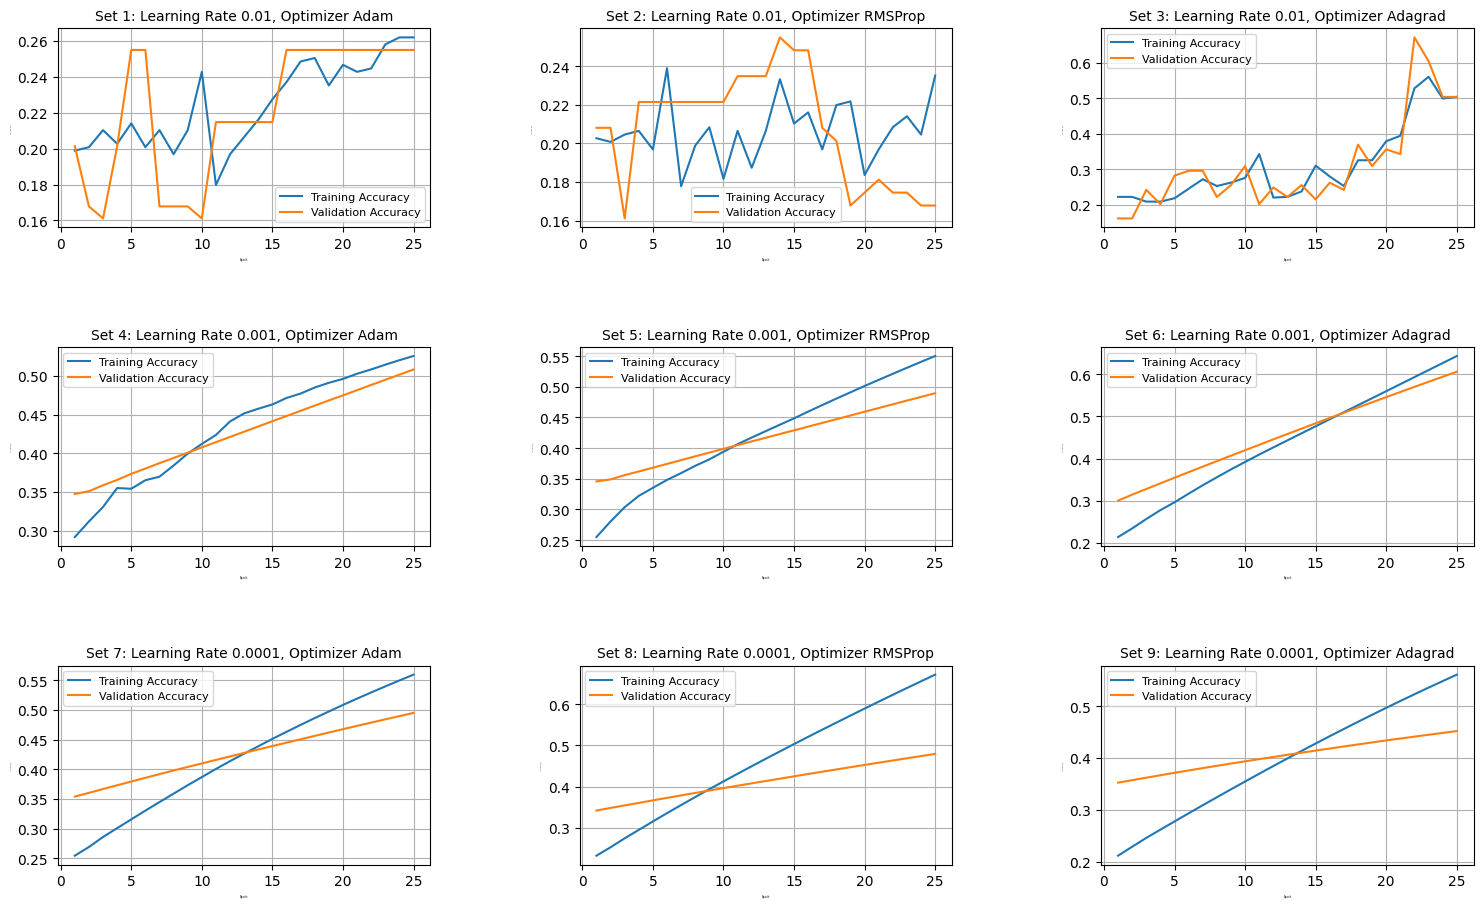

In [ ]:
def plot_epoch_vs_accuracy(train_accuracies, val_accuracies, epochs, title, ax):
    """
    Plots the epoch vs accuracy graph for training and validation datasets.

    Parameters:
        train_accuracies (list): List of training accuracies for each epoch.
        val_accuracies (list): List of validation accuracies for each epoch.
        epochs (int): Total number of epochs.
        title (str): Title for the plot.
        ax (matplotlib.axes.Axes): Axis object to plot on.
    """
    ax.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    ax.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Epoch', fontsize=2)
    ax.set_ylabel('Accuracy (%)', fontsize=1)
    ax.legend(fontsize=8)
    ax.grid(True)


# Create a grid for the plots
fig = plt.figure(figsize=(25, 15))
gs = gridspec.GridSpec(4, 4, wspace=0.4, hspace=0.6)

# Generate plots for each dataset
for idx, data in enumerate(acc):
    ax = fig.add_subplot(gs[idx // 3, idx % 3])
    plot_epoch_vs_accuracy(data['train_accuracies'], data['val_accuracies'], len(data['train_accuracies']), data['title'], ax)

plt.tight_layout()
plt.show()


In [ ]:
max_vgg=[]
for i in range(9):
  max_vgg.append(max(acc[i]['val_accuracies']))

In [ ]:
titles_vgg=[]
for i in range(9):
  titles_vgg.append(acc[i]['title'])

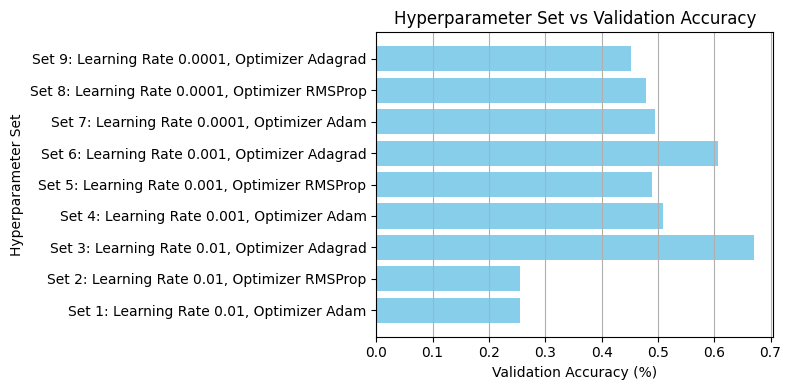

In [ ]:
# Plot the hyperparameter set vs accuracy
plt.figure(figsize=(8, 4))
hyperparam_keys = titles_vgg
hyperparam_accuracies = max_vgg
plt.barh(hyperparam_keys, hyperparam_accuracies, color='skyblue')
plt.xlabel("Validation Accuracy (%)")
plt.ylabel("Hyperparameter Set")
plt.title("Hyperparameter Set vs Validation Accuracy")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

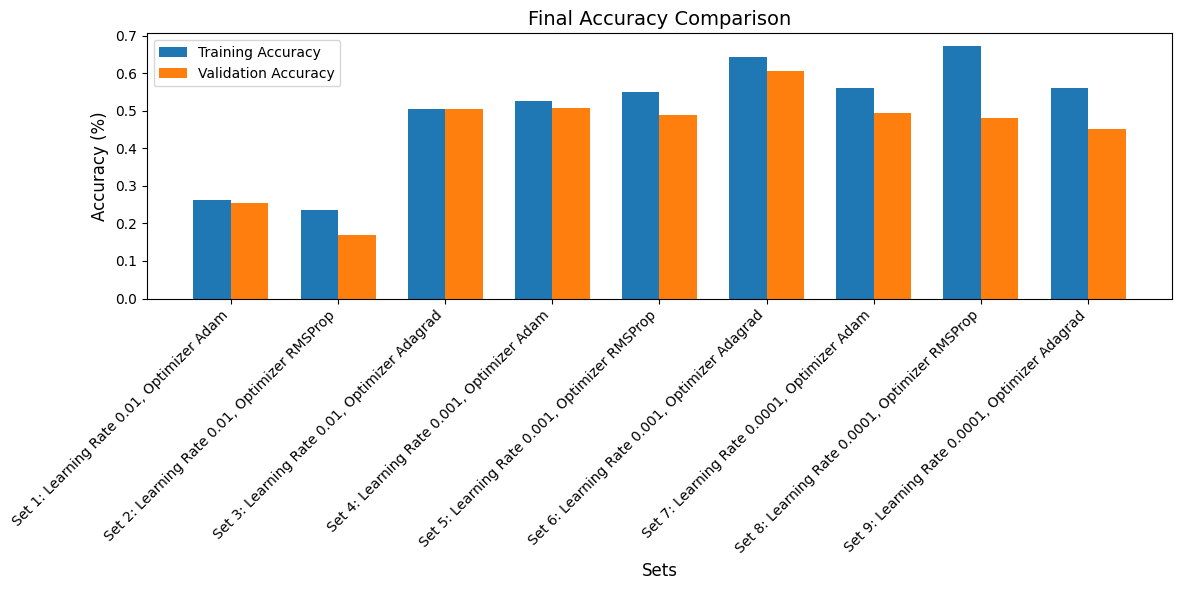

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_epoch_vs_accuracy(train_accuracies, val_accuracies, epochs, title):
    """
    Plots the epoch vs accuracy graph for training and validation datasets.

    Parameters:
        train_accuracies (list): List of training accuracies for each epoch.
        val_accuracies (list): List of validation accuracies for each epoch.
        epochs (int): Total number of epochs.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='s')

    plt.title(title, fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(range(1, epochs + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_final_accuracy_comparison(acc):
    """
    Plots a bar chart comparing final training and validation accuracies for all sets.

    Parameters:
        acc (list): List of dictionaries containing train_accuracies, val_accuracies, and titles for each set.
    """
    titles = [data['title'] for data in acc]
    final_train_accuracies = [data['train_accuracies'][-1] for data in acc]
    final_val_accuracies = [data['val_accuracies'][-1] for data in acc]

    x = np.arange(len(titles))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, final_train_accuracies, width, label='Training Accuracy')
    plt.bar(x + width/2, final_val_accuracies, width, label='Validation Accuracy')

    plt.title('Final Accuracy Comparison', fontsize=14)
    plt.xlabel('Sets', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(x, titles, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_optimizer_comparison(acc, learning_rate):
    """
    Plots a grouped bar chart comparing optimizers for a fixed learning rate.

    Parameters:
        acc (list): List of dictionaries containing train_accuracies, val_accuracies, and titles for each set.
        learning_rate (float): The learning rate to filter data sets.
    """
    filtered_data = [data for data in acc if f'Learning Rate {learning_rate}' in data['title']]
    optimizers = [data['title'].split('Optimizer ')[1] for data in filtered_data]
    avg_train_accuracies = [np.mean(data['train_accuracies']) for data in filtered_data]
    avg_val_accuracies = [np.mean(data['val_accuracies']) for data in filtered_data]

    x = np.arange(len(optimizers))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, avg_train_accuracies, width, label='Avg Training Accuracy')
    plt.bar(x + width/2, avg_val_accuracies, width, label='Avg Validation Accuracy')

    plt.title(f'Optimizer Comparison (Learning Rate {learning_rate})', fontsize=14)
    plt.xlabel('Optimizers', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(x, optimizers)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_learning_rate_impact(acc):
    """
    Plots a line graph showing the impact of learning rate on average accuracies.

    Parameters:
        acc (list): List of dictionaries containing train_accuracies, val_accuracies, and titles for each set.
    """
    learning_rates = sorted(set(float(data['title'].split('Learning Rate ')[1].split(',')[0]) for data in acc))
    avg_train_accuracies = []
    avg_val_accuracies = []

    for lr in learning_rates:
        filtered_data = [data for data in acc if f'Learning Rate {lr}' in data['title']]
        avg_train_accuracies.append(np.mean([np.mean(data['train_accuracies']) for data in filtered_data]))
        avg_val_accuracies.append(np.mean([np.mean(data['val_accuracies']) for data in filtered_data]))

    plt.figure(figsize=(12, 6))
    plt.plot(learning_rates, avg_train_accuracies, label='Avg Training Accuracy', marker='o')
    plt.plot(learning_rates, avg_val_accuracies, label='Avg Validation Accuracy', marker='s')

    plt.title('Impact of Learning Rate on Accuracy', fontsize=14)
    plt.xlabel('Learning Rate', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(learning_rates)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Generate additional plots
plot_final_accuracy_comparison(acc)
print("\n")



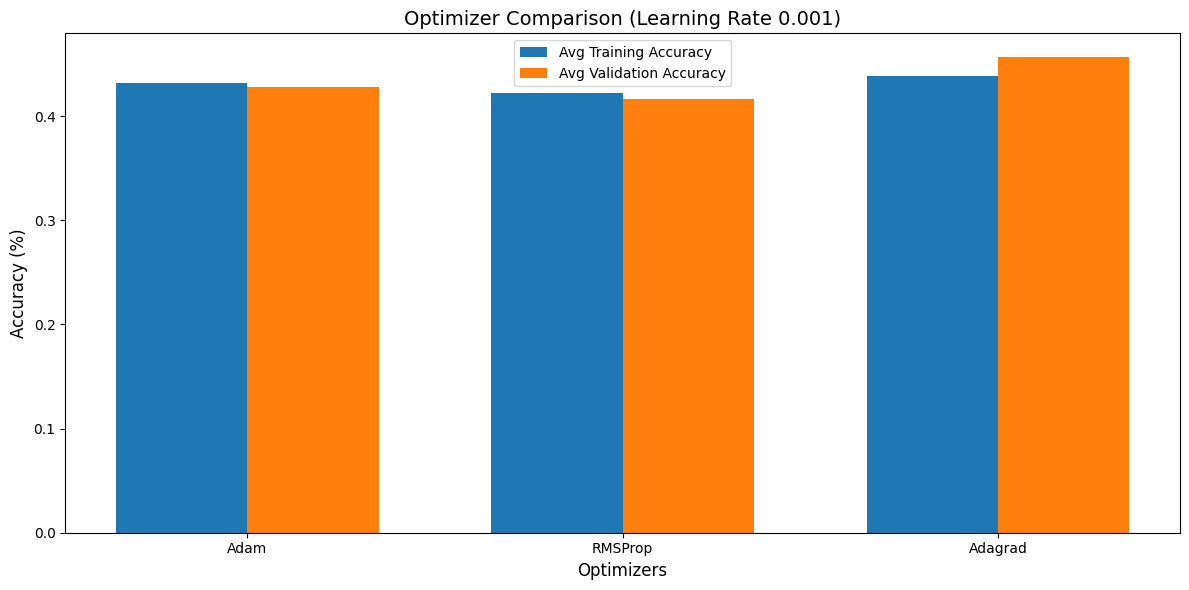

In [ ]:
plot_optimizer_comparison(acc, learning_rate=0.001)

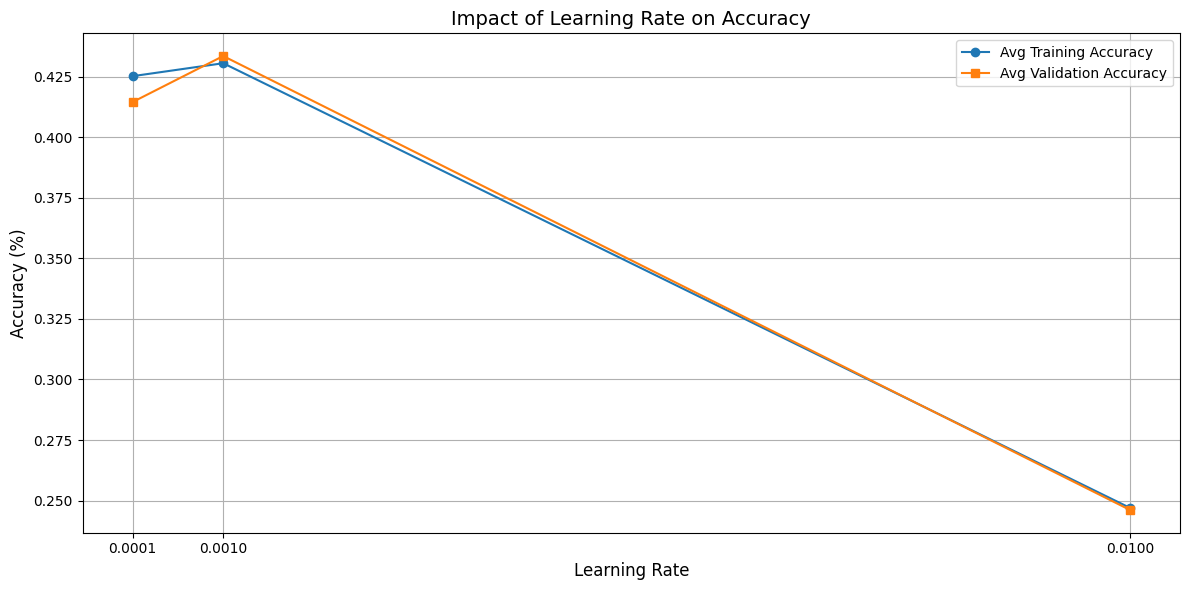

In [ ]:
plot_learning_rate_impact(acc)